In [1]:
import pandas as pd
import numpy as np
import sys
import geopandas as gpd
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString
from rtree import index
import osmnx as ox
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import itertools
from tqdm import tqdm
from IPython.display import IFrame, display, clear_output, HTML
import geopandas as gpd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from collections import deque
%matplotlib notebook
import heapq
import math 
import copy
import gym
from torch.nn.init import kaiming_uniform_, zeros_
from sklearn.neighbors import NearestNeighbors
from concurrent.futures import ThreadPoolExecutor
import warnings
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
grid_data_path = f'target_zones_grid250m_EPSG3067.geojson'
work = f'HMA_Dynamic_population_24H_workdays.csv'
sun = f'HMA_Dynamic_population_24H_sun.csv'
sat = f'HMA_Dynamic_population_24H_sat.csv'

In [3]:
gdf = gpd.read_file(grid_data_path)
gdf.crs='EPSG:3067'
gdf

,YKR_ID,geometry
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."
...,...,...
13226,6016698,"POLYGON ((373000.000 6665500.000, 372750.000 6..."
13227,6016699,"POLYGON ((373250.000 6665500.000, 373000.000 6..."
13228,6018252,"POLYGON ((372500.000 6665250.000, 372250.000 6..."
13229,6018253,"POLYGON ((372750.000 6665250.000, 372500.000 6..."


In [784]:
gdf_selected

,geometry
0,"POLYGON ((384000.000 6676500.000, 384125.000 6..."
1,"POLYGON ((384125.000 6676500.000, 384250.000 6..."
2,"POLYGON ((384000.000 6676625.000, 384125.000 6..."
3,"POLYGON ((384125.000 6676625.000, 384250.000 6..."
4,"POLYGON ((384250.000 6676500.000, 384375.000 6..."
...,...
1151,"POLYGON ((387875.000 6672625.000, 388000.000 6..."
1152,"POLYGON ((388000.000 6672500.000, 388125.000 6..."
1153,"POLYGON ((388125.000 6672500.000, 388250.000 6..."
1154,"POLYGON ((388000.000 6672625.000, 388125.000 6..."


In [786]:
1156**0.5

34.0

In [4]:
# left_up = (384250, 6676000)
# right_down = (387500, 6672750)


left_up = (384250, 6676750)
right_down = (388250, 6672750)


# left_up = (385750, 6674500)
# right_down = (387500, 6672750)

<IPython.core.display.Javascript object>


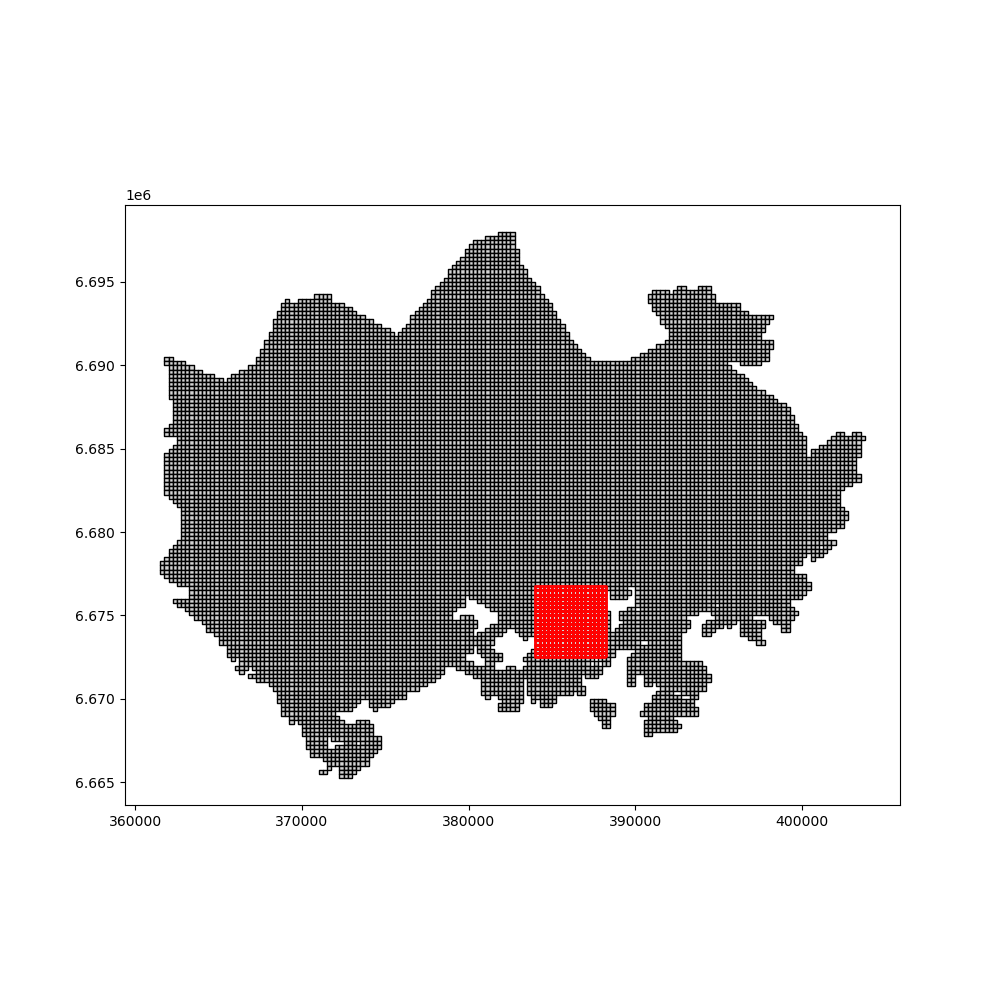

In [5]:
selected_region = box(left_up[0], right_down[1], right_down[0], left_up[1])
gdf_selected = gdf[gdf.intersects(selected_region)]
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="lightgrey", edgecolor="black") 
gdf_selected.boundary.plot(ax=ax, color="red", linewidth=2)
plt.show()

In [47]:
gdf_selected

,geometry
0,"POLYGON ((384000.000 6676500.000, 384125.000 6..."
1,"POLYGON ((384125.000 6676500.000, 384250.000 6..."
2,"POLYGON ((384000.000 6676625.000, 384125.000 6..."
3,"POLYGON ((384125.000 6676625.000, 384250.000 6..."
4,"POLYGON ((384250.000 6676500.000, 384375.000 6..."
...,...
1151,"POLYGON ((387875.000 6672625.000, 388000.000 6..."
1152,"POLYGON ((388000.000 6672500.000, 388125.000 6..."
1153,"POLYGON ((388125.000 6672500.000, 388250.000 6..."
1154,"POLYGON ((388000.000 6672625.000, 388125.000 6..."


In [2]:
minx, miny, maxx, maxy = gdf_selected.total_bounds
cell_width = gdf_selected['geometry'].iloc[0].bounds[2] - gdf_selected['geometry'].iloc[0].bounds[0]
cell_height = gdf_selected['geometry'].iloc[0].bounds[3] - gdf_selected['geometry'].iloc[0].bounds[1]
num_cells_width = int((maxx - minx) / cell_width)
num_cells_height = int((maxy - miny) / cell_height)
cell_table = pd.DataFrame(index=range(1, num_cells_height + 1), columns=range(1, num_cells_width + 1))
for idx, row in gdf_selected.iterrows():
    centroid = row['geometry'].centroid
    col_index = int((centroid.x - minx) / cell_width) + 1
    row_index = int((maxy - centroid.y) / cell_height) + 1
    cell_table.at[row_index, col_index] = row['YKR_ID']
matrix = cell_table.to_numpy()
cell_table

In [ ]:
work_df = pd.read_csv(work) #sun / sat
work_df = work_df[work_df['YKR_ID'].isin(gdf_selected['YKR_ID'].unique())]
work_gdf = gdf_selected.merge(work_df, on='YKR_ID').drop(columns='YKR_ID')
work_gdf

In [ ]:
def divide_polygon(polygon, rows, cols):
    minx, miny, maxx, maxy = polygon.bounds
    width = (maxx - minx) / cols
    height = (maxy - miny) / rows
    polygons = []

    for i in range(rows):
        for j in range(cols):
            new_poly = Polygon([
                (minx + j * width, miny + i * height),
                (minx + (j + 1) * width, miny + i * height),
                (minx + (j + 1) * width, miny + (i + 1) * height),
                (minx + j * width, miny + (i + 1) * height),
                (minx + j * width, miny + i * height),  
            ])
            polygons.append(new_poly)

    return polygons

In [ ]:
rows = 2
cols = 2  

new_geometries = []
new_values = []

for idx, row in work_gdf.iterrows():
    polygons = divide_polygon(row['geometry'], rows, cols)
    
    values = row[1:].values 
    distributed_values = values / (rows * cols)

    for poly in polygons:
        new_geometries.append(poly)
        new_values.append(distributed_values)

new_gdf = gpd.GeoDataFrame(new_geometries, columns=['geometry'])
new_values_df = pd.DataFrame(new_values, columns=work_df.columns[1:])  
work_gdf = pd.concat([new_gdf, new_values_df], axis=1)
work_gdf.reset_index(drop=True, inplace=True)

In [ ]:
def generate_random_factors(num_intervals):
    return np.random.uniform(1e-5, 1e-3, num_intervals)

def resample_to_5min(df):
    new_df = pd.DataFrame()
    for idx, row in df.iterrows():
        hourly_data = row[1:]
        for col in hourly_data.index:
            for i in range(12):  # For each 15-minute interval
                random_factor = generate_random_factors(1)[0]
                new_value = hourly_data[col] * random_factor
                time_index = f"{col}_{i*5}min"
                new_df.at[idx, time_index] = new_value
        new_df.at[idx, 'geometry'] = row['geometry']

    return new_df

In [12]:
work_gdf = resample_to_5min(work_gdf)
work_gdf

C:\Users\T470P\AppData\Local\Temp\ipykernel_8652\2082525196.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df.at[idx, time_index] = new_value
C:\Users\T470P\AppData\Local\Temp\ipykernel_8652\2082525196.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df.at[idx, time_index] = new_value
C:\Users\T470P\AppData\Local\Temp\ipykernel_8652\2082525196.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

,H0_0min,H0_5min,H0_10min,H0_15min,H0_20min,H0_25min,H0_30min,H0_35min,H0_40min,H0_45min,...,H23_15min,H23_20min,H23_25min,H23_30min,H23_35min,H23_40min,H23_45min,H23_50min,H23_55min,geometry
0,2.449488e-07,4.253522e-07,5.098873e-07,7.517402e-07,1.152217e-07,2.377395e-07,7.668288e-08,6.628494e-07,3.435029e-07,8.181342e-07,...,2.934916e-07,7.665479e-07,3.607172e-07,6.711011e-07,8.094635e-07,1.482485e-07,5.989406e-07,4.565064e-07,5.698942e-07,"POLYGON ((384000.0001389217 6676500.00013214, ..."
1,1.982957e-08,2.494985e-07,3.943501e-07,1.699756e-07,7.299302e-07,4.695614e-07,4.751537e-07,4.009784e-07,4.383667e-07,7.760002e-07,...,5.113222e-07,8.083565e-07,3.540307e-07,8.057718e-07,1.102457e-08,6.948879e-07,7.182696e-07,2.283237e-07,3.704084e-07,"POLYGON ((384125.00013889745 6676500.00013214,..."
2,7.069216e-07,4.182272e-07,7.252338e-07,4.948381e-08,2.894703e-07,4.350200e-07,1.549478e-07,1.942611e-07,2.587767e-07,6.550776e-07,...,3.259822e-07,5.345321e-07,1.281821e-07,3.929139e-07,3.662691e-08,2.559118e-07,7.710401e-07,6.919499e-07,7.638916e-07,"POLYGON ((384000.0001389217 6676625.000132121,..."
3,4.603748e-07,4.106281e-08,6.371188e-07,7.626018e-07,5.372296e-07,1.779094e-07,4.206230e-07,3.185958e-07,6.845972e-07,5.313235e-07,...,3.739249e-07,7.247856e-07,2.752653e-07,8.211751e-07,5.581250e-07,2.717120e-07,3.455855e-07,6.075536e-08,8.759985e-08,POLYGON ((384125.00013889745 6676625.000132121...
4,1.582808e-06,1.627217e-06,1.158018e-06,1.630310e-06,1.012461e-06,2.175829e-07,6.145325e-07,2.126415e-07,2.683524e-07,2.344663e-07,...,5.595292e-07,4.412283e-07,1.159067e-06,1.338647e-07,1.737263e-06,1.067275e-06,1.493975e-06,1.250839e-07,9.629262e-07,POLYGON ((384250.00013886567 6676500.000132134...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,5.362401e-09,6.387045e-09,1.339921e-08,4.753167e-10,1.373036e-08,1.065942e-08,5.679387e-09,8.052731e-09,6.634106e-09,9.303046e-09,...,2.555452e-09,9.367726e-09,3.709039e-09,8.949674e-09,4.995914e-09,5.685954e-09,8.907744e-09,5.014043e-09,9.577785e-10,"POLYGON ((387875.0001381774 6672625.000132778,..."
1152,3.231189e-08,3.156621e-08,3.178656e-08,3.262469e-08,1.837155e-08,1.511299e-08,5.265211e-09,9.394099e-09,6.497901e-09,2.712315e-08,...,1.299800e-08,3.439262e-09,1.659167e-08,1.817563e-08,5.428084e-09,1.987474e-08,1.582690e-08,3.915438e-09,2.102847e-08,"POLYGON ((388000.0001381475 6672500.000132792,..."
1153,1.792167e-08,7.323707e-09,1.723743e-08,2.593062e-08,1.189217e-08,1.692969e-08,3.728634e-09,2.568470e-08,2.265586e-09,2.375366e-08,...,1.471699e-08,1.943577e-08,2.398435e-08,1.935682e-09,5.007205e-09,1.416638e-08,9.789644e-09,7.923186e-10,2.445985e-08,"POLYGON ((388125.0001381232 6672500.000132792,..."
1154,1.947532e-08,3.160747e-08,6.855879e-09,2.387243e-08,4.782936e-09,2.424701e-08,8.417753e-09,3.146121e-08,2.769924e-08,1.237658e-08,...,2.488185e-08,2.116319e-08,4.114688e-09,2.343560e-08,2.689492e-08,7.076004e-09,1.278560e-08,1.305582e-09,1.178746e-09,"POLYGON ((388000.0001381475 6672625.000132769,..."


In [13]:
non_geometry_columns = work_gdf.drop(columns='geometry')
normalized_columns = (non_geometry_columns - non_geometry_columns.min()) / (non_geometry_columns.max() - non_geometry_columns.min())
work_gdf_normalized = work_gdf[['geometry']].join(normalized_columns)
work_gdf_normalized = gpd.GeoDataFrame(work_gdf_normalized, geometry='geometry')

In [14]:
work_gdf_normalized

,geometry,H0_0min,H0_5min,H0_10min,H0_15min,H0_20min,H0_25min,H0_30min,H0_35min,H0_40min,...,H23_10min,H23_15min,H23_20min,H23_25min,H23_30min,H23_35min,H23_40min,H23_45min,H23_50min,H23_55min
0,"POLYGON ((384000.000 6676500.000, 384125.000 6...",0.002587,0.005020,0.006237,0.008618,0.001172,0.002785,0.001157,0.011148,0.004519,...,0.013540,0.005976,0.008482,0.004399,0.008963,0.009525,0.001667,0.007743,0.005153,0.008110
1,"POLYGON ((384125.000 6676500.000, 384250.000 6...",0.000209,0.002942,0.004823,0.001948,0.007434,0.005500,0.007175,0.006742,0.005768,...,0.012968,0.010411,0.008945,0.004318,0.010762,0.000130,0.007814,0.009285,0.002577,0.005271
2,"POLYGON ((384000.000 6676625.000, 384125.000 6...",0.007469,0.004936,0.008871,0.000566,0.002947,0.005096,0.002339,0.003264,0.003404,...,0.011476,0.006637,0.005915,0.001563,0.005248,0.000431,0.002878,0.009967,0.007810,0.010871
3,"POLYGON ((384125.000 6676625.000, 384250.000 6...",0.004864,0.000479,0.007793,0.008742,0.005471,0.002084,0.006351,0.005356,0.009009,...,0.002056,0.007613,0.008020,0.003357,0.010968,0.006567,0.003056,0.004467,0.000686,0.001247
4,"POLYGON ((384250.000 6676500.000, 384375.000 6...",0.016723,0.019224,0.014167,0.018691,0.010312,0.002548,0.009279,0.003573,0.003530,...,0.001111,0.011392,0.004882,0.014135,0.001788,0.020442,0.012002,0.019313,0.001412,0.013703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,"POLYGON ((387875.000 6672625.000, 388000.000 6...",0.000056,0.000069,0.000162,0.000004,0.000138,0.000124,0.000085,0.000130,0.000084,...,0.000192,0.000052,0.000104,0.000045,0.000120,0.000059,0.000064,0.000115,0.000057,0.000014
1152,"POLYGON ((388000.000 6672500.000, 388125.000 6...",0.000341,0.000366,0.000387,0.000373,0.000186,0.000177,0.000079,0.000153,0.000082,...,0.000288,0.000265,0.000038,0.000202,0.000243,0.000064,0.000224,0.000205,0.000044,0.000299
1153,"POLYGON ((388125.000 6672500.000, 388250.000 6...",0.000189,0.000080,0.000209,0.000296,0.000120,0.000198,0.000055,0.000427,0.000027,...,0.000415,0.000300,0.000215,0.000293,0.000026,0.000059,0.000159,0.000127,0.000009,0.000348
1154,"POLYGON ((388000.000 6672625.000, 388125.000 6...",0.000205,0.000367,0.000082,0.000273,0.000047,0.000284,0.000126,0.000524,0.000362,...,0.000065,0.000507,0.000234,0.000050,0.000313,0.000316,0.000080,0.000165,0.000015,0.000017


In [15]:

def time_to_interval(seconds):
    seconds_per_day = 24 * 3600  
    if seconds < 0 or seconds >= seconds_per_day:
        return None  
    interval_duration = 300  # 5-minute interval in seconds
    interval_num = seconds // interval_duration
    
    hours = interval_num // 12  # 12 intervals of 5 minutes per hour
    minutes = (interval_num % 12) * 5  # Multiply by 5 for each interval
    return f"H{hours}_{minutes}min"

In [16]:
gdf = gdf_selected.to_crs(epsg=4326)
cell_geometry = gdf['geometry'].iloc[4]  
data = ox.features.features_from_polygon(cell_geometry, tags={'building': True})
data

nodes  \
element_type osmid                                                          
way          4254311    [25477874, 25477875, 339925920, 339925922, 339...   
             30732205   [339886792, 339886794, 339886796, 339886798, 3...   
             177159977  [1876126739, 1876126737, 1876126735, 187612672...   
             177159980  [1876126775, 1876126773, 25477242, 1876126777,...   
             177159983  [1876126758, 1876126747, 1876126733, 187612674...   

                       addr:housenumber addr:street    building layer  \
element_type osmid                                                      
way          4254311                 44   Veturitie  industrial     1   
             30732205                44   Veturitie         yes   NaN   
             177159977               44   Veturitie  industrial     1   
             177159980               44   Veturitie  industrial     1   
             177159983              NaN         NaN        shed   NaN   

                               name  \
element_type osmid                    
way          4254311     Vaunuhalli   
             30732205           NaN   
             177159977  Pesuhalli 2   
             177159980   Pendohalli   
             177159983          NaN   

                                                                 geometry  \
element_type osmid                                                          
way          4254311    POLYGON ((24.92888 60.21116, 24.92912 60.21112...   
             30732205   POLYGON ((24.92818 60.20993, 24.92811 60.20981...   
             177159977  POLYGON ((24.92534 60.20949, 24.92526 60.20950...   
             177159980  POLYGON ((24.92760 60.20983, 24.92751 60.20984...   
             177159983  POLYGON ((24.92803 60.20967, 24.92833 60.20963...   

                       railway  
element_type osmid              
way          4254311       NaN  
             30732205      NaN  
             177159977    wash  
             177159980     NaN  
             177159983     NaN

In [17]:
def get_building_obstacles(gdf_selected, min_building_height=8):
    gdf = gdf_selected.to_crs(epsg=4326)
    cell_info = []
    for c in range(len(gdf)):
        try:
            data = ox.features.features_from_polygon(gdf['geometry'].iloc[c], tags={'building': True})
            for i in range(len(data)):
                building_geom = data['geometry'].iloc[i]
                if 'building:levels' in data.columns:
                    building_height = data['building:levels'].iloc[i]
                else:
                    building_height = None
                if pd.isna(building_height) or building_height == "nan":
                    building_height = 0
                try:
                    building_height = float(building_height)
                except ValueError:
                    building_height = 0  
                if building_height > min_building_height:
                    cell_info.append({
                        'YKR_ID': gdf['YKR_ID'].iloc[c],
                        'geometry': building_geom
                    })
        except ox._errors.InsufficientResponseError:
            continue
    gdf_obstacles = gpd.GeoDataFrame(cell_info, geometry='geometry')
    gdf_obstacles.crs = "EPSG:4326"
    gdf_obstacles = gdf_obstacles.to_crs(epsg=3067)
    return gdf_obstacles

In [18]:
gdf_obstacles = get_building_obstacles(gdf_selected, 8)

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common

C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\T470P\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
 

In [19]:
gdf_obstacles

,YKR_ID,geometry
0,5943980,"POLYGON ((388101.718 6676722.132, 388101.068 6..."
1,5945785,"POLYGON ((387959.988 6676346.024, 387953.803 6..."
2,5947588,"POLYGON ((387466.331 6675963.413, 387466.369 6..."
3,5947589,"POLYGON ((387505.358 6676044.935, 387510.945 6..."
4,5947589,"POLYGON ((387612.228 6676089.647, 387616.535 6..."
...,...,...
174,5970463,"POLYGON ((386648.513 6672780.363, 386648.898 6..."
175,5970464,"POLYGON ((386845.162 6672753.030, 386850.812 6..."
176,5972102,"POLYGON ((386354.996 6672566.152, 386344.872 6..."
177,5972104,"POLYGON ((386862.560 6672737.369, 386870.436 6..."


In [20]:
def divide_polygons(gdf, rows, cols):
    def divide_polygon(polygon, rows, cols):
        minx, miny, maxx, maxy = polygon.bounds
        width = (maxx - minx) / cols
        height = (maxy - miny) / rows
        polygons = []
        for i in range(rows):
            for j in range(cols):
                new_poly = Polygon([
                    (minx + j * width, miny + i * height),
                    (minx + (j + 1) * width, miny + i * height),
                    (minx + (j + 1) * width, miny + (i + 1) * height),
                    (minx + j * width, miny + (i + 1) * height),
                    (minx + j * width, miny + i * height), 
                ])
                polygons.append(new_poly)
        return polygons
    new_geometries = []
    for _, row in gdf.iterrows():
        if isinstance(row['geometry'], Polygon):  
            polygons = divide_polygon(row['geometry'], rows, cols)
            new_geometries.extend(polygons)  
    new_gdf = gpd.GeoDataFrame(new_geometries, columns=['geometry'])
    new_gdf.reset_index(drop=True, inplace=True)

    return new_gdf

In [21]:
rows = 2
cols = 2  
gdf_selected = divide_polygons(gdf_selected, rows, cols)
gdf_selected.crs='epsg:3067'

<IPython.core.display.Javascript object>


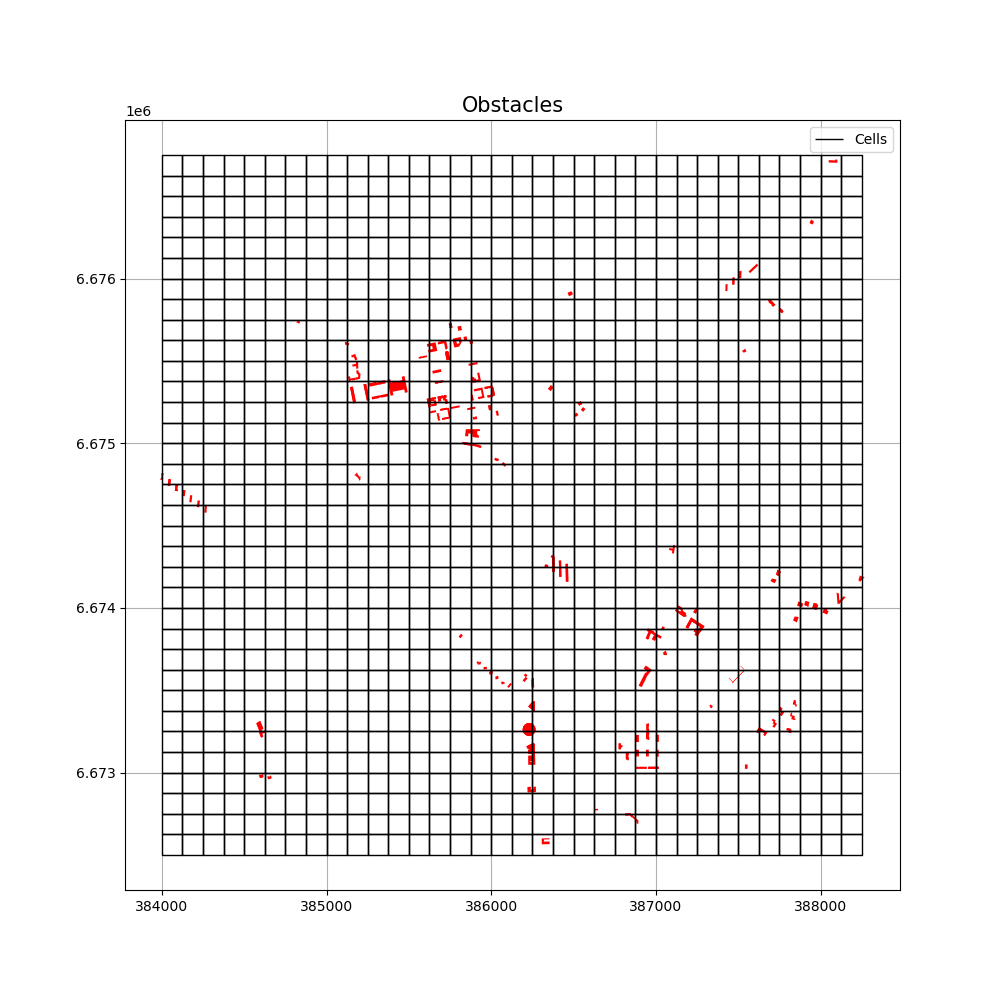

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_selected.boundary.plot(ax=ax, color='black', linewidth=1, label='Cells')
gdf_obstacles.plot(ax=ax, color='red', alpha=1, label='Obstacles')
ax.set_title("Obstacles", fontsize=15)
ax.legend(loc='upper right')
ax.grid(True)
plt.show()

In [49]:
def get_building_obstacles(gdf_selected, min_building_height=8):
    gdf = gdf_selected.to_crs(epsg=4326)
    cell_info = []
    for c in range(len(gdf)):
        try:
            data = ox.features.features_from_polygon(gdf['geometry'].iloc[c], tags={'building': True})
            for i in range(len(data)):
                building_geom = data['geometry'].iloc[i]
                if 'building:levels' in data.columns:
                    building_height = data['building:levels'].iloc[i]
                else:
                    building_height = None
                if pd.isna(building_height) or building_height == "nan":
                    building_height = 0
                try:
                    building_height = float(building_height)
                except ValueError:
                    building_height = 0  
                if building_height > min_building_height:
                    cell_info.append({
                        'YKR_ID': gdf['YKR_ID'].iloc[c],
                        'geometry': building_geom,
                        'height': building_height  
                    })
        except ox._errors.InsufficientResponseError:
            continue
    gdf_obstacles = gpd.GeoDataFrame(cell_info, geometry='geometry')
    gdf_obstacles.crs = "EPSG:4326"
    gdf_obstacles = gdf_obstacles.to_crs(epsg=3067)
    return gdf_obstacles

In [50]:
# gdf_obstacles = get_building_obstacles(gdf_selected, 8)

In [25]:
def plot_3d(gdf_all_cells, found_paths, z_level, epsg_target=3067, plot_size=(20, 10), elevation=90, azimuth=270):
    gdf_all_cells = gdf_all_cells.to_crs(epsg=epsg_target)
    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(111, projection='3d')
    for index, row in gdf_all_cells.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            x_coords, y_coords = row['geometry'].exterior.xy
            dx = max(x_coords) - min(x_coords)
            dy = max(y_coords) - min(y_coords)
            ax.plot(x_coords, y_coords, zs=0, zdir='z', alpha=0.5, color='lightgrey')
            if 'height' in row and row['height'] > 0:
                ax.bar3d(min(x_coords), min(y_coords), 0, 
                         dx=dx, dy=dy, dz=row['height'], 
                         color='blue', alpha=0.6)
        elif row['geometry'].geom_type == 'Point':
            ax.scatter(row['geometry'].x, row['geometry'].y, zs=0, color='red', s=50)
    if found_paths:
        path_x = [point.x for point in found_paths]
        path_y = [point.y for point in found_paths]
        ax.plot(path_x, path_y, zs=z_level, color='black', linewidth=2)
        ax.scatter(path_x[0], path_y[0], zs=z_level, color='green', s=100, marker='o')
        ax.scatter(path_x[-1], path_y[-1], zs=z_level, color='red', s=100, marker='x')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Height (floors)')
    ax.set_title('3D Plot of Buildings and Cells with Found Paths')
    ax.view_init(elev=elevation, azim=azimuth)
    
    plt.show()

In [26]:
# plot_3d(gdf_obstacles, found_paths[0], 8)

In [27]:
def plot_3d(gdf_all_cells, path, path_height=8, output_file='3d_buildings_path_plot.html'):
    path_coords = np.array([[point.x, point.y] for point in path])
    fig = go.Figure()
    for index, row in gdf_all_cells.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            coords = np.array(row['geometry'].exterior.xy)
            x = coords[0]
            y = coords[1]
            z_base = np.zeros_like(x)  
            z_top = np.ones_like(x) * row['height']  
            vertices_x = np.concatenate([x, x])
            vertices_y = np.concatenate([y, y])
            vertices_z = np.concatenate([z_base, z_top])
            faces = np.arange(len(x))  
            faces_top = faces + len(x)  
            i, j, k = [], [], [] 
            for m in range(len(x) - 1):
                i += [faces[m], faces[m], faces[m + 1]]
                j += [faces[m + 1], faces_top[m], faces[m + 1]]
                k += [faces_top[m], faces_top[m + 1], faces_top[m + 1]]
            i += [faces[-1], faces[-1], faces[0]]
            j += [faces[0], faces_top[-1], faces[0]]
            k += [faces_top[-1], faces_top[0], faces_top[0]]
            fig.add_trace(go.Mesh3d(
                x=vertices_x,
                y=vertices_y,
                z=vertices_z,
                i=i, j=j, k=k,
                opacity=0.6,
                color='blue',
                showscale=False  
            ))
        elif row['geometry'].geom_type == 'Point':
            fig.add_trace(go.Scatter3d(
                x=[row['geometry'].x],
                y=[row['geometry'].y],
                z=[0],  
                mode='markers',
                marker=dict(color='red', size=5),
                showlegend=False  
            ))
    fig.add_trace(go.Scatter3d(
        x=path_coords[:, 0],
        y=path_coords[:, 1],
        z=[path_height] * len(path_coords), 
        mode='lines',
        line=dict(color='orange', width=3),
        name='A* Path'
    ))
    start_point = path_coords[0]
    fig.add_trace(go.Scatter3d(
        x=[start_point[0]],
        y=[start_point[1]],
        z=[path_height],
        mode='markers',
        marker=dict(color='green', size=8),
        name='Start Point'
    ))
    target_point = path_coords[-1]
    fig.add_trace(go.Scatter3d(
        x=[target_point[0]],
        y=[target_point[1]],
        z=[path_height],
        mode='markers',
        marker=dict(color='blue', size=8),
        name='Target Point'
    ))
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Height (floors)',
            camera_eye=dict(x=0, y=-2, z=1.5),  
            aspectratio=dict(x=1, y=1, z=0.5),
            aspectmode='manual'
        ),
        title='3D Plot of Buildings, A* Path, and Points',
        width=800,
        height=600,
    )
    pio.write_html(fig, file=output_file, auto_open=False)

In [28]:
# plot_3d(gdf_obstacles, found_paths[0], 8, '3d.html')

In [29]:
import math

In [30]:
minx, miny, maxx, maxy = gdf_selected.total_bounds

In [31]:
max_distance = (maxx-minx)*(2**0.5)

In [32]:
def calculate_action_in_degrees(start, end):
    if isinstance(start, tuple):
        start = Point(start[0], start[1])
    if isinstance(end, tuple):
        end = Point(end[0], end[1])    
    delta_x = end.x - start.x
    delta_y = end.y - start.y    
    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)    
    if angle_degrees < 0:
        angle_degrees += 360
    return angle_degrees

In [33]:
class State:

    def __init__(self, day, time, angle,
                       current_x, current_y,
                       target_x, target_y,):
        self.day = day
        self.time = time
        self.hour = time//3600
        self.minutes = int((time/3600 - time//3600)*60)
        self.seconds = time - (self.hour*60 + self.minutes)*60
        self.angle = angle
        self.current_x = current_x
        self.current_y = current_y
        self.target_x = target_x
        self.target_y = target_y
        self.ob_matrix = generate_obstacle_array((current_x, current_y), obstacle_coords, 50)
        
    def to_tuple(self):         
        return [
#             self.hour/8,
#             self.minutes/60,
#             self.seconds/60,
            self.angle/359,
            (self.current_x - minx) / (maxx - minx),
            (self.current_y - miny) / (maxy - miny),
            (self.target_x - minx) / (maxx - minx),
            (self.target_y - miny) / (maxy - miny),
#             *self.ob_matri
        ]

In [34]:
def calculate_angle(point1, point2):
    x1, y1 = point1.x, point1.y
    x2, y2 = point2.x, point2.y
    angle_rad = math.atan2(y2 - y1, x2 - x1)
    angle_deg = math.degrees(angle_rad)
    if angle_deg < 0:
        angle_deg += 360
    angle_deg = (angle_deg + 270) % 360
    angle_deg = 360 - angle_deg
    return angle_deg

In [35]:
def get_cell_bounds(current_x, current_y):
    point = Point(current_x, current_y)
    point_series = gpd.GeoSeries([point], crs="epsg:3067")
    point_series = point_series.to_crs(gdf_selected.crs)
    for index, row in gdf_selected.iterrows():
        if point_series.within(row['geometry']).any():
            bounds = row['geometry'].bounds
            if bounds:
                return bounds
            else:
                return (None, None, None, None)
    return None, None, None, None

In [36]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [37]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma):
        super(NoisyLinear, self).__init__()
        self.w_mu = nn.Parameter(torch.empty((out_features, in_features)))
        self.w_sigma = nn.Parameter(torch.empty((out_features, in_features)))
        self.b_mu = nn.Parameter(torch.empty((out_features)))
        self.b_sigma = nn.Parameter(torch.empty((out_features)))
        kaiming_uniform_(self.w_mu, a=math.sqrt(5))
        kaiming_uniform_(self.w_sigma, a=math.sqrt(5))
        zeros_(self.b_mu)
        zeros_(self.b_sigma)
    def forward(self, x, sigma=0.5):
        if self.training:
            w_noise = torch.normal(0, sigma, size=self.w_mu.size()).to(device)
            b_noise = torch.normal(0, sigma, size=self.b_mu.size()).to(device)
            return F.linear(x, self.w_mu + self.w_sigma * w_noise, self.b_mu + self.b_sigma * b_noise)
        else:
            return F.linear(x, self.w_mu, self.b_mu)

In [38]:
class Noisy_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_actions, optimizer=optim.AdamW, learning_rate=1e-4, max_grad_norm=1.0):
        super(Noisy_QNet, self).__init__()
        self.net = nn.Sequential(
            NoisyLinear(input_size, hidden_size, sigma=0.2),
            nn.LayerNorm(hidden_size),  
            nn.ReLU(),
            NoisyLinear(hidden_size, hidden_size, sigma=0.2),
            nn.LayerNorm(hidden_size),  
            nn.ReLU(),
            NoisyLinear(hidden_size, hidden_size, sigma=0.2),
            nn.LayerNorm(hidden_size),  
            nn.ReLU(),
            NoisyLinear(hidden_size, hidden_size, sigma=0.2),
            nn.LayerNorm(hidden_size),  
            nn.ReLU(),
            NoisyLinear(hidden_size, hidden_size, sigma=0.2),
            nn.LayerNorm(hidden_size),  
            nn.ReLU(),
            NoisyLinear(hidden_size, n_actions, sigma=0.2),
        )
        self.value = nn.Sequential(
            NoisyLinear(hidden_size, hidden_size, sigma=0.2),
            nn.LayerNorm(hidden_size),  
            nn.ReLU(),
            NoisyLinear(hidden_size, 1, sigma=0.2)
        )
        self.adv = nn.Sequential(
            NoisyLinear(hidden_size, hidden_size, sigma=0.2),
            nn.LayerNorm(hidden_size),  
            nn.ReLU(),
            NoisyLinear(hidden_size, n_actions, sigma=0.2)
        )
        self.input_shape = (input_size,)
        self.n_actions = n_actions
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        self.loss_function = F.mse_loss
        self.learning_rate = learning_rate
        self.max_grad_norm = max_grad_norm
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x = self.net(x)
        #adv = self.adv(x)
        #value = self.value(x)
        #adv = adv.view(-1, self.n_actions)
        return x # adv + value - torch.mean(adv, dim=1, keepdim=True) value + adv - torch.mean(adv, dim=1, keepdim=True)
    def update_parameters(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), self.max_grad_norm)
        self.optimizer.step()

In [39]:

def generate_path(gdf_obstacles, gdf_selected, start, target, safety_distance=50):
    buffered_obstacles = gdf_obstacles.copy()
    buffered_obstacles['geometry'] = buffered_obstacles.geometry.buffer(safety_distance)
    obstacle_index = index.Index()
    for idx, geom in enumerate(buffered_obstacles.geometry):
        obstacle_index.insert(idx, geom.bounds)
    start_position = start
    target_position = target
    sampled_gdf_selected = gdf_selected.iloc[::3]
    grid_points = [geometry.centroid for geometry in sampled_gdf_selected.geometry if not geometry.is_empty]
    all_points = [start_position] + grid_points + [target_position]
    G = nx.Graph()
    for i, point in enumerate(all_points):
        G.add_node(i, pos=(point.x, point.y))
    for i, point1 in enumerate(all_points):
        for j, point2 in enumerate(all_points):
            if i != j:
                line = LineString([point1, point2])
                if not any(line.intersects(buffered_obstacles.geometry[idx]) for idx in obstacle_index.intersection(line.bounds)):
                    distance = point1.distance(point2)
                    G.add_edge(i, j, weight=distance)  
    start_idx = 0  
    target_idx = len(all_points) - 1  
    try:
        shortest_path_indices = nx.dijkstra_path(G, source=start_idx, target=target_idx, weight='weight')
        best_path = [all_points[idx] for idx in shortest_path_indices]
        best_path_line = LineString(best_path)
        print("Best path found with length:", best_path_line.length)
    except nx.NetworkXNoPath:
        best_path = None
        best_path_line = None
        print("No valid path found between start and target.")
    visibility_lines = [LineString([all_points[i], all_points[j]]) for i, j in G.edges]
    gdf_visibility = gpd.GeoDataFrame(geometry=visibility_lines, crs=gdf_obstacles.crs)
    return gdf_visibility, best_path_line, buffered_obstacles, all_points

In [52]:
buffered_obstacles = gdf_obstacles.copy()
buffered_obstacles['geometry'] = buffered_obstacles.geometry.buffer(50)
obstacle_index = index.Index()

In [53]:
def plot_graph(gdf_visibility, best_path_line, buffered_obstacles, all_points, start, target, gdf_selected):
    fig, ax = plt.subplots(figsize=(10, 10))
    buffered_obstacles.plot(ax=ax, color='red', alpha=0.5, label='Obstacles with Safety Buffer')
    gdf_selected.boundary.plot(ax=ax, color='black', linewidth=1, label='Grid Cells')
    ax.scatter([start.x], [start.y], color='green', label='Start', zorder=5)
    ax.scatter([target.x], [target.y], color='orange', label='Target', zorder=5)
    x_path = [point.x for point in best_path]
    y_path = [point.y for point in best_path]
    ax.plot(x_path, y_path, color='blue', linewidth=2, label='Path')
    ax.set_title("Visibility Graph with Best Path from Start to Target", fontsize=15)
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.show()

In [54]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.capacity = capacity
        self.alpha = 1.0
        self.beta = 0.5
        self.max_priority = 0.0
    def __len__(self):
        return len(self.buffer)
    def append(self, experience):
        self.buffer.append(experience)
        self.priorities.append(self.max_priority)
    def update(self, index, priority):
        if priority > self.max_priority:
            self.max_priority = priority
        self.priorities[index] = priority
    def sample(self, batch_size, device):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        prios = np.array(self.priorities, dtype=np.float64) + 1e-4
        prios = prios ** self.alpha
        probs = prios / prios.sum()
        weights = (self.__len__() * probs) ** -self.beta
        weights = weights / weights.max()
        idx = random.choices(range(self.__len__()), weights=probs, k=batch_size)
        samples = [(i, weights[i], *self.buffer[i]) for i in idx]
        indexes, weights, states, actions, rewards, next_states, dones = zip(*samples)
        weights = torch.tensor(weights, dtype=torch.float32).to(device)
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.bool).to(device)
        return indexes, weights, states, actions, rewards, next_states, dones

In [55]:
centroids = buffered_obstacles.geometry.centroid
obstacle_coords = [(point.x, point.y) for point in centroids]

In [56]:
def get_risk(df, point, column_name):
    if not isinstance(df, gpd.GeoDataFrame):
        raise ValueError("Input df is not a GeoDataFrame")
    row = df[df['geometry'].apply(lambda geom: geom.contains(point))]    
    if not row.empty:
        return row[column_name].values[0]    
    return 0  

In [57]:
def generate_obstacle_array(position, obstacle_coords, max_distance):
    # Initialize the obstacle array with 0s
    obstacle_array = [0] * 8
    pos_x, pos_y = position
    
    # Convert obstacle_coords to Point objects for distance checks
    obstacle_points = [Point(x, y) for (x, y) in obstacle_coords]
    
    # Define directions in degrees: from 0 to 360, every 10 degrees
    directions = list(range(0, 360, 45))
    
    # Calculate potential positions based on max_distance
    for i, direction in enumerate(directions):
        direction_radians = math.radians(direction)
        
        # Calculate new position based on the max distance
        new_x = pos_x + max_distance * math.cos(direction_radians)
        new_y = pos_y + max_distance * math.sin(direction_radians)
        
        # Check if the new position is within the environmental bounds
        if new_x < minx or new_x > maxx or new_y < miny or new_y > maxy:
            obstacle_array[i] = 1  # Mark as obstacle if out of bounds
            continue  # Move to the next direction
        
        # Create a point for the new position
        new_position = Point(new_x, new_y)
        
        # Check if the new position is close to any obstacle
        is_obstacle = any(obstacle.distance(new_position) <= max_distance for obstacle in obstacle_points)
        
        # Set the corresponding array index to 1 if there's an obstacle
        if is_obstacle:
            obstacle_array[i] = 1
    
    return obstacle_array

In [58]:
class Env(gym.Env):
    def __init__(self, render, min_time=21600, max_time=25500,
                 speed=20,time_granularity=1):
        super(Env, self).__init__()
        self.state = None
        self.speed = speed
        self.time_granularity = time_granularity
        self.render = render
        self.min_time = min_time
        self.max_time = max_time
        self.max_distance = math.sqrt((minx-maxx)**2 + (miny-maxy)**2)
        print(self.max_distance)
    def reset(self):
        day = 1
        time = random.randint(self.min_time, self.max_time)

        dist = random.uniform(4200, 4200)

        while True:
            finish = True
            angle = random.uniform(0, 2 * np.pi)
            delta_x = dist * np.cos(angle)
            delta_y = dist * np.sin(angle)
            current_x, current_y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
            target_x = current_x + delta_x
            target_y = current_y + delta_y
            if minx <= target_x <= maxx and miny <= target_y <= maxy:
                for coords in obstacle_coords:
                    start_distance = math.sqrt((current_x - coords[0]) ** 2 + (current_y - coords[1]) ** 2)
                    target_distance = math.sqrt((target_x - coords[0]) ** 2 + (target_y - coords[1]) ** 2)
                    if start_distance <= 100 or target_distance <= 100:
                        finish = False
                        break  # Exit the obstacle loop if we hit an issue
                        
                if finish == True:    
                    break
        
        angle = calculate_angle(Point(current_x, current_y), Point(target_x, target_y))
        self.state = State(day, time, angle,
                           current_x, current_y,
                           target_x, target_y)
        
        return self.state

    def set_state(self, state):
        self.state = state
        self.start_x = state.current_x
        self.start_y = state.current_y
    def step(self, action): 
        action=action*20
        direction_radians = math.radians(action)
        distance = self.speed 
        delta_distance = distance*self.time_granularity
        new_x = self.state.current_x + delta_distance*math.cos(direction_radians)
        new_y = self.state.current_y + delta_distance*math.sin(direction_radians)
        if( (new_x < minx) or (new_x > maxx) or (new_y < miny) or (new_y > maxy) ):
            return self.state, -1, False
        else:
            prev_state = copy.copy(self.state)
            
            min_distance = float('inf')  
            for coords in obstacle_coords:
                distance = math.sqrt((new_x - coords[0])**2 + (new_y - coords[1])**2)
                if distance < 100:
                    return self.state, -1, False
            
            
            time = self.state.time + self.time_granularity
            angle = calculate_angle(Point(new_x, new_y), Point(self.state.target_x, self.state.target_y))
            self.state = State(self.state.day, time, angle,
                           new_x, new_y,
                           self.state.target_x, self.state.target_y)
            current_target_distance =  math.sqrt((self.state.target_x - new_x)**2 + (self.state.target_y - new_y)**2)
            
            if (current_target_distance <= (self.time_granularity*self.speed)):
                return self.state, 1, True
            
            risk = get_risk(work_gdf_normalized, Point(self.state.current_x, self.state.current_y), time_to_interval(self.state.time))
            dist = (current_target_distance/self.max_distance)
            return self.state, (-0.4*dist-0.6*risk), False

In [59]:
class HerReplayBuffer:
    def __init__(self, capacity, her_probability=0.8):
        self.buffer = deque(maxlen=capacity//2)
        self.her_buffer = deque(maxlen=capacity//2)
        self.her_probability = 0.6


    def __len__(self):
        return len(self.buffer) + len(self.her_buffer)


    def append(self, experience, her=False):
        if her:
            self.buffer.append(experience)
        else:
            self.her_buffer.append(experience)


    def sample(self, batch_size, device):
        her_batch_size = int(batch_size*self.her_probability)
        regular_batch_size = batch_size - her_batch_size
        
        batch = random.sample(self.buffer, regular_batch_size)
        her_batch = random.sample(self.her_buffer, her_batch_size)
        
        full_batch = list(batch+her_batch)
        random.shuffle(full_batch)
        
#         if batch_size > len(self.buffer):
#             batch_size = len(self.buffer)
#         samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*full_batch)
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.bool).to(device)
        return states, actions, rewards, next_states, dones

In [60]:
class DDQNAgent:

    def __init__(self, model, device, replay_buffer, num_actions=8, discount=0.9,
                 batch_size=1_000, max_memory=100_000, target_update_freq=50,
                eps_start=1.0, eps_end=0.3, eps_last_episode=500, her=0.8, a_start=0.5, a_end=0.0, a_last_episode=100, 
               b_start=0.4, b_end=1.0, b_last_episode=100):
        self.device = device
        self.time = ''
        self.policy_net = Noisy_QNet(5, 128, 18).to(self.device)
        self.target_net = copy.deepcopy(self.policy_net).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.num_actions = num_actions
        self.discount = discount
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.current_epoch = 0
        self.eps_start = eps_start
        self.eps_last_episode = eps_last_episode
        self.batch_size = batch_size
        self.num_actions = num_actions
        self.memory = replay_buffer
        self.target_update_freq = target_update_freq
        self.weighted_returns = []
        self.returns = []
        self.ep_dist =[]
        self.losses = []
        self.steps = []
        self.a_start=a_start
        self.a_end=a_end
        self.a_last_episode=a_last_episode
        self.alpha = a_start
        self.b_start=b_start
        self.b_end=b_end
        self.b_last_episode=b_last_episode
        self.beta = b_start
        

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


    def update_epsilon(self):
        self.epsilon = max(
            self.eps_end,
            self.eps_start - self.current_epoch / self.eps_last_episode
        )
        alpha = max(
            self.a_end,
            self.a_start - self.current_epoch / self.a_last_episode
        )
        beta = min(
            self.b_end,
            self.b_start + self.current_epoch / self.b_last_episode
        )
        self.memory.alpha = alpha
        self.memory.beta = beta

        
        
#     def learn(self):
#         if(len(self.memory.her_buffer)< self.batch_size and len(self.memory.buffer)< self.batch_size):
#             return None
#         states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size, self.device)
#         actions = actions.unsqueeze(1)
#         rewards = rewards.unsqueeze(1)
#         dones = dones.unsqueeze(1)
        
#         state_action_values = self.policy_net(states).gather(1, actions)
#         with torch.no_grad():
#             _, next_actions = self.policy_net(next_states).max(dim=1, keepdim=True)
#             next_action_values = self.target_net(next_states).gather(1, next_actions)
#             next_action_values[dones] = 0.0
#         expected_state_action_values = rewards + (self.discount) * next_action_values
#         loss = self.policy_net.loss_function(state_action_values, expected_state_action_values)
#         self.policy_net.update_parameters(loss)
#         return loss.item()

    def learn(self):
        if(len(self.memory)< self.batch_size):
            return None
        indices, weights, states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size, device)
        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)
        
        
        state_action_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            _, next_actions = self.policy_net(next_states).max(dim=1, keepdim=True)
            next_action_values = self.target_net(next_states).gather(1, next_actions)
            next_action_values[dones] = 0.0
        expected_state_action_values = rewards + (self.discount) * next_action_values
        td_errors = (state_action_values - expected_state_action_values).abs().detach()

        for idx, e in zip(indices, td_errors):
            self.memory.update(idx, e.item())
        
        loss = weights * self.policy_net.loss_function(state_action_values, expected_state_action_values, reduction='none')
        loss = loss.mean()
        self.policy_net.update_parameters(loss)
        
        return loss.item()

        
    

    def get_action(self, state, env):
        state_ = copy.copy(state)
#         print(state.to_tuple())

        state = torch.tensor(state.to_tuple(), dtype=torch.float).to(self.device)
        q_values = self.policy_net(state)
#         q_values[state_.ob_matrix] = float('-inf')
        
        action = torch.argmax(q_values).item()
        return action


    def train(self, env, n_episodes=1, cell_size=50, max_steps=700):
        steps = 0
        best = -50
        for ep in tqdm(range(n_episodes), desc="Episodes", unit="episode"):
            self.current_epoch +=1
            state = STATE #env.reset()
            env.set_state(state)
#             state = env.reset()
            _return = 0
            actions = 0
            done = False
            positions = []
            start_position = Point(state.current_x, state.current_y)
            target_position = Point(state.target_x, state.target_y)
            transitions = []
            for j in range(max_steps):
                action = self.get_action(state, env)
                new_state, reward, done = env.step(action)   
                _return += reward
#                 if reward != -1:
                self.memory.append((state.to_tuple(), action, reward, new_state.to_tuple(), done))
#                 if state_her_p != None:
#                     self.memory.append((state_her_p.to_tuple(), action, reward_her, state_her_a.to_tuple(), done_her), her=True)
                steps+=1
                actions+=1
                loss = self.learn()
                if loss is not None:
                    self.losses.append(loss)
                positions.append(Point(state.current_x, state.current_y))
                state = new_state
                if(steps % self.target_update_freq == 0):
                    self.update_target_net()
                if(done):
                    break
            self.returns.append(_return)
            self.steps.append(actions)
            
            render(gdf_visibility=None, buffered_obstacles=buffered_obstacles, gdf_selected=gdf_selected, path=positions, target_position=target_position, waypoints=None, rewards=self.returns, 
                   losses=self.losses, steps=self.steps)
            self.update_epsilon()

In [61]:
def render(gdf_visibility, buffered_obstacles, gdf_selected, path=None, target_position=None, waypoints=None, rewards=None, losses=None, steps=None):
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(3, 2, width_ratios=[2, 1])  
    ax_left = fig.add_subplot(gs[:, 0])  
    buffered_obstacles.plot(ax=ax_left, color='red', alpha=1, label='Obstacles with Safety Buffer')
    gdf_selected.boundary.plot(ax=ax_left, color='black', linewidth=1, label='Grid Cells')
    if path is not None:
        x_path = [point.x for point in path]
        y_path = [point.y for point in path]
        ax_left.plot(x_path, y_path, color='blue', linewidth=2, label='Path')
        start_point = path[0]
        ax_left.plot(start_point.x, start_point.y, 'go', markersize=10, label='Start Point')
        if target_position is not None:
            ax_left.scatter(target_position.x, target_position.y, c='green', marker='x', s=100, label='Target Point')
        
    ax_left.set_title("Visibility Graph with Grid Connections and Safety Distance", fontsize=15)
    ax_left.legend(loc='upper right')
    ax_left.grid(True)
    ax1 = fig.add_subplot(gs[0, 1])  
    ax2 = fig.add_subplot(gs[1, 1])  
    ax3 = fig.add_subplot(gs[2, 1])  
    if steps is not None:
        ax1.plot(steps, label='Steps', color='blue')
        ax1.set_title("Steps Over Time", fontsize=12)
        ax1.grid(True)
    if losses is not None:
        ax2.plot(losses, label='Losses', color='red')
        ax2.set_title("Losses Over Time", fontsize=12)
        ax2.grid(True)
    if rewards is not None:
        ax3.plot(rewards, label='Rewards', color='green')
        ax3.set_title("Rewards Over Time", fontsize=12)
        ax3.grid(True)
    clear_output(wait=True)
    plt.tight_layout()
    plt.show()

In [62]:
ENV_PARAMS = {
    'speed' : 5,
    'time_granularity' :10,
    'render' : render,
    'min_time' : 24300,
    'max_time' : 24300,
}

In [63]:
DDQNAGENT_PARAMS = {
    'model' : Noisy_QNet(8, 128, 360),
    'device' : device,
    'replay_buffer' : PrioritizedReplayBuffer(50_000),
    'discount' : 0.97,
    'batch_size' : 64,
    'max_memory' : 50_000,
    'target_update_freq' : 100,
    'a_start' : 0.5,
    'a_end' : 0.0,
    'a_last_episode' : 6000, 
    'b_start' : 0.4,
    'b_end' : 1.0,
    'b_last_episode' : 6000,
}

C:\Users\T470P\anaconda3\lib\site-packages\huggingface_hub\inference\_text_generation.py:121: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  @validator("best_of")
C:\Users\T470P\anaconda3\lib\site-packages\huggingface_hub\inference\_text_generation.py:140: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  @validator("repetition_penalty")
C:\Users\T470P\anaconda3\lib\site-packages\huggingface_hub\inference\_text_generation.py:146: Pydan

In [64]:
%matplotlib inline

In [65]:
env = Env(**ENV_PARAMS)
agent = DDQNAgent(**DDQNAGENT_PARAMS)

6010.407639017207


In [66]:
import networkx as nx
import pickle

In [595]:
# agent.policy_net.load_state_dict(torch.load('models_2/state_5.pth'))

# with open('models_2/state_5.pkl', 'rb') as f:
#     STATE = pickle.load(f)[0] 

# STATE = copy.copy(STATE)

In [596]:
def total_distance(points):
    def distance(p1, p2):
        return math.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)
    
    total_dist = 0
    for i in range(len(points) - 1):
        total_dist += distance(points[i], points[i + 1])
    
    return total_dist

In [597]:
def resample_line_points(line, interval=50):
    resampled_points = []
    current_distance = 0
    
    while current_distance <= line.length:
        point = line.interpolate(current_distance)
        resampled_points.append((point.x, point.y))
        current_distance += interval

    # Append the last point if it isn't exactly at an interval
    if (point.x, point.y) != (line.coords[-1][0], line.coords[-1][1]):
        resampled_points.append((line.coords[-1][0], line.coords[-1][1]))

    return resampled_points

In [598]:
def calculate_cumulative_risk(points):
    total_risk = 0
    t = STATE.time
    for i in range(len(points) - 1):
        point1 = points[i]
        point2 = points[i + 1]
        # Calculate distance between points
        distance = calculate_distance(point1, point2)
        
        # Interpolate points if the distance is greater than 50 meters
        if distance > 50:
            interpolated_points = interpolate_points(point1, point2)
            for opoint in interpolated_points:
                risk = get_risk(work_gdf_normalized, Point(opoint[0], opoint[1]), time_to_interval(t))
                total_risk += risk  # Accumulate risk
        else:
            total_risk += get_risk(work_gdf_normalized, Point(point2[0], point2[1]), time_to_interval(t))
            
        t+=10    
    return total_risk

In [599]:
class Env(gym.Env):
    def __init__(self, render, min_time=21600, max_time=25500,
                 speed=20,time_granularity=1):
        super(Env, self).__init__()
        self.state = None
        self.speed = speed
        self.time_granularity = time_granularity
        self.render = render
        self.min_time = min_time
        self.max_time = max_time
        self.max_distance = math.sqrt((minx-maxx)**2 + (miny-maxy)**2)
        print(self.max_distance)
    def reset(self):
        day = 1
        time = random.randint(self.min_time, self.max_time)

        dist = random.uniform(2000, 2000)

        while True:
            finish = True
            angle = random.uniform(0, 2 * np.pi)
            delta_x = dist * np.cos(angle)
            delta_y = dist * np.sin(angle)
            current_x, current_y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
            target_x = current_x + delta_x
            target_y = current_y + delta_y
            if minx <= target_x <= maxx and miny <= target_y <= maxy:
                for coords in obstacle_coords:
                    start_distance = math.sqrt((current_x - coords[0]) ** 2 + (current_y - coords[1]) ** 2)
                    target_distance = math.sqrt((target_x - coords[0]) ** 2 + (target_y - coords[1]) ** 2)
                    if start_distance <= 100 or target_distance <= 100:
                        finish = False
                        break  # Exit the obstacle loop if we hit an issue
                        
                if finish == True:    
                    break
        
        angle = calculate_angle(Point(current_x, current_y), Point(target_x, target_y))
        self.state = State(day, time, angle,
                           current_x, current_y,
                           target_x, target_y)
        
        return self.state

    def set_state(self, state):
        self.state = state
        self.start_x = state.current_x
        self.start_y = state.current_y
    def step(self, action): 
        action=action*20
        direction_radians = math.radians(action)
        distance = self.speed 
        delta_distance = distance*self.time_granularity
        new_x = self.state.current_x + delta_distance*math.cos(direction_radians)
        new_y = self.state.current_y + delta_distance*math.sin(direction_radians)
        if( (new_x < minx) or (new_x > maxx) or (new_y < miny) or (new_y > maxy) ):
            return self.state, -1, -1, False
        else:
            prev_state = copy.copy(self.state)
            
            min_distance = float('inf')  
            for coords in obstacle_coords:
                distance = math.sqrt((new_x - coords[0])**2 + (new_y - coords[1])**2)
                if distance < 100:
                    return self.state, -1, -1, False
            
            
            time = self.state.time + self.time_granularity
            angle = calculate_angle(Point(new_x, new_y), Point(self.state.target_x, self.state.target_y))
            self.state = State(self.state.day, time, angle,
                           new_x, new_y,
                           self.state.target_x, self.state.target_y)
            current_target_distance =  math.sqrt((self.state.target_x - new_x)**2 + (self.state.target_y - new_y)**2)
            
            if (current_target_distance <= (self.time_granularity*self.speed)):
                return self.state, self.time_granularity*self.speed, 1, True
            
            risk = get_risk(work_gdf_normalized, Point(self.state.current_x, self.state.current_y), time_to_interval(self.state.time))
            dist = (current_target_distance)
            return self.state, self.time_granularity*self.speed, risk, False

In [600]:
env = Env(**ENV_PARAMS)

6010.407639017207


In [813]:
agent.policy_net.load_state_dict(torch.load('models_2/state_4.pth'))

with open('models_2/state_4.pkl', 'rb') as f:
    STATE = pickle.load(f)[0] 

STATE = copy.copy(STATE)

In [814]:
risk_r = 0
dist_r = 0
state = copy.copy(STATE)
env.set_state(state)
done=False
positions = []
positions.append(Point(state.current_x, state.current_y))
# positions.append((state.target_x, state.target_y))

steps = 0
for i in range(120):
    steps+=1
    q_values = agent.policy_net(torch.tensor(state.to_tuple(), dtype=torch.float).to(device))        
    action = torch.argmax(q_values).item()
    next_state, reward_d, reward_r, done = env.step(action)
    dist_r+=reward_d
    if done:
        break
    positions.append(Point(next_state.current_x, next_state.current_y))
    risk_r+=reward_r
    state = next_state
    
positions.append(Point(state.target_x, state.target_y))

In [815]:
risk_r, dist_r

(2.841898326298736, 4700)

In [816]:
distance = 0
risk = 0

time = STATE.time

for i in range(len(positions) - 1):
    distance+= positions[i].distance(positions[i + 1])
    risk += get_risk(work_gdf_normalized, positions[i+1], time_to_interval(time))
    time+=10

In [817]:
distance, risk

(4704.3101992955, 2.9113159048489776)

In [818]:
len(positions)

95

In [819]:
risks_ddqn = [3.5968178500570573, 3.6431510693074802, 2.705311579431666, 3.2108067081064267, 3.803056471912262]

distances_ddqn = [4602.360147480624, 4657.080005070698, 5036.237274033779, 4675.7400661548245, 5406.0383545733675]

In [820]:
coordinates = [(point.x, point.y) for point in positions]
min_distances = distance_to_obstacles(coordinates, obstacle_coords)
np.mean(min_distances)

375.625619857481

In [821]:
do_ddqn = [269.6468652701196, 360.0311114250979, 316.66538244312545, 372.66950110025743, 303.2318832850866]

In [822]:
def calculate_smoothness(waypoints):
    angles = []
    
    # Calculate angles between each consecutive segment
    for i in range(1, len(waypoints) - 1):
        p1 = np.array(waypoints[i - 1])
        p2 = np.array(waypoints[i])
        p3 = np.array(waypoints[i + 1])
        
        # Calculate vectors
        v1 = p2 - p1
        v2 = p3 - p2
        
        # Calculate angle in radians
        angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
        angle = np.degrees(angle)  # Convert to degrees
        angle = angle % 360  # Normalize to [0, 360)
        
        # Store angles only if they are less than 180 degrees
        if angle > 180:
            angle = 360 - angle
        
        angles.append(angle)
    
    # Calculate average change in angle
    if angles:
        average_angle_change = np.mean(angles)
        return average_angle_change
    else:
        return float('inf')  # Return infinity if there are not enough waypoints

# Example usage

In [823]:
smoothness_score = calculate_smoothness(coordinates)
print(f"Smoothness Score: {smoothness_score:.2f} degrees")

Smoothness Score: 12.13 degrees


In [824]:
smooth_ddqn = [4.12, 20.56, 11.22, ]

In [825]:
centroids = buffered_obstacles.geometry.centroid
centroid_coords = np.array([centroid.coords[0] for centroid in centroids])

Best path found.


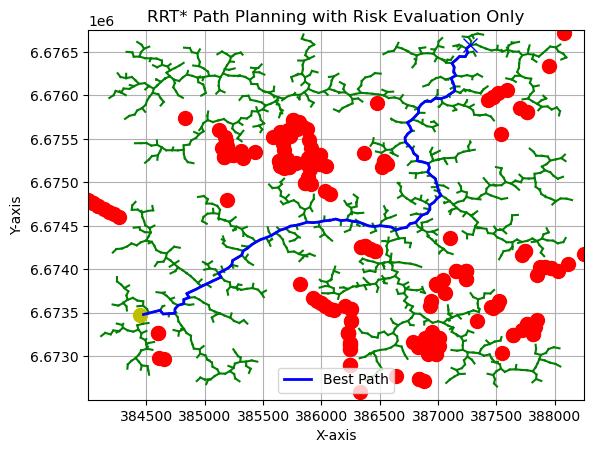

In [869]:
import random
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point


class Node:
    def __init__(self, position, parent=None):
        self.position = position
        self.parent = parent
        self.cost = 0  # Cost to reach this node

def distance(node1, node2):
    return np.linalg.norm(np.array(node1.position) - np.array(node2.position))

def point_to_segment_distance(point, start, end):
    """Calculate the distance from a point to a line segment."""
    start = np.array(start)
    end = np.array(end)
    point = np.array(point)
    
    # Vector from start to end
    segment = end - start
    segment_length_squared = np.dot(segment, segment)
    
    if segment_length_squared == 0:  # start and end are the same point
        return np.linalg.norm(point - start)
    
    # Projection of point onto the line segment
    t = np.dot(point - start, segment) / segment_length_squared
    t = np.clip(t, 0, 1)  # Clamp t to the segment
    projection = start + t * segment
    
    return np.linalg.norm(point - projection)

def is_collision_free(node1, node2, obstacles, buffer_distance=100):
    """Check if the path between node1 and node2 is free of obstacles within a buffer distance."""
    for obs in obstacles:
        if point_to_segment_distance(obs, node1.position, node2.position) < buffer_distance:
            return False
    return True

def get_nearest_node(tree, random_node):
    return min(tree, key=lambda node: distance(node, random_node))

def rewire(tree, new_node, radius, obstacles):
    for node in tree:
        if distance(node, new_node) < radius and is_collision_free(node, new_node, obstacles):
            new_cost = node.cost + distance(node, new_node)
            if new_cost < new_node.cost:
                new_node.parent = node
                new_node.cost = new_cost

class Node:
    def __init__(self, position, parent=None):
        self.position = position
        self.parent = parent
        self.cost = 0  # Total cost from the start node

def distance(node_a, node_b):
    """Calculate the Euclidean distance between two nodes."""
    return np.linalg.norm(np.array(node_a.position) - np.array(node_b.position))

def get_nearest_node(tree, random_node):
    """Find the nearest node in the tree to the random node."""
    return min(tree, key=lambda node: distance(node, random_node))

def rrt_star_with_risk(start, goal, obstacles, work_gdf_normalized, max_iter=2000, step_size=50, radius=1, goal_sample_rate=0.1):
    tree = [Node(start)]
    
    for _ in range(max_iter):
        # Occasionally sample the goal to increase the likelihood of reaching it
        if random.random() < goal_sample_rate:
            random_position = goal
        else:
            random_position = (random.uniform(minx, maxx), random.uniform(miny, maxy))
        random_node = Node(random_position)

        nearest_node = get_nearest_node(tree, random_node)
        direction = np.array(random_node.position) - np.array(nearest_node.position)
        if np.linalg.norm(direction) > step_size:
            direction = (direction / np.linalg.norm(direction)) * step_size
        new_position = nearest_node.position + direction
        new_node = Node(new_position, nearest_node)

        # Calculate risk for the new node
        risk = get_risk(work_gdf_normalized, Point(new_position), time_to_interval(STATE.time))
#         new_node.cost = nearest_node.cost + risk  # Only consider risk in cost
        new_node.cost = nearest_node.cost + (0.5 * distance(nearest_node, new_node) / max_distance + 0.5 * risk)

        # Add the node if it is collision-free
        if is_collision_free(nearest_node, new_node, obstacles):
            tree.append(new_node)
            rewire(tree, new_node, radius, obstacles)

    # Find the path to the goal by searching nodes close to the goal
    goal_node = min(
        [node for node in tree if distance(node, Node(goal)) <= step_size and is_collision_free(node, Node(goal), obstacles)],
        key=lambda node: node.cost, default=None
    )

    # Backtrack to retrieve the path from start to goal if the goal is reachable
    if goal_node:
        best_path = []
        current_node = goal_node
        while current_node:
            best_path.append(current_node.position)
            current_node = current_node.parent
        best_path.reverse()  # Start from the start position
        print("Best path found.")
    else:
        best_path = []
        print("Goal not reachable within the iterations.")

    return tree, best_path

# Example usage with placeholders for start and goal points
start = (STATE.current_x, STATE.current_y)
goal = (STATE.target_x, STATE.target_y)

tree, best_path = rrt_star_with_risk(start, goal, centroid_coords, work_gdf_normalized)

# Draw the resulting tree and the best path
def draw_tree(tree, obstacles, best_path):
    for node in tree:
        if node.parent:
            plt.plot([node.position[0], node.parent.position[0]],
                     [node.position[1], node.parent.position[1]], 'g-')
    for obs in obstacles:
        plt.plot(obs[0], obs[1], 'ro', markersize=10)
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    plt.plot(start[0], start[1], 'bx', markersize=10)
    plt.plot(goal[0], goal[1], 'yo', markersize=10)
    plt.grid()
    
    if best_path:
        best_path = np.array(best_path)
        plt.plot(best_path[:, 0], best_path[:, 1], 'b-', linewidth=2, label='Best Path')
        
    plt.title("RRT* Path Planning with Risk Evaluation Only")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.show()

draw_tree(tree, centroid_coords, best_path)


In [870]:
point_list = [Point(node[0], node[1]) for node in best_path]
len(point_list)

114

In [871]:
len(point_list)

114

In [872]:
distance = 0
risk = 0

time = STATE.time

for i in range(len(point_list) - 1):
    distance+= point_list[i].distance(point_list[i + 1])
    risk += get_risk(work_gdf_normalized, point_list[i+1], time_to_interval(time))
    time+=10

In [873]:
distance, risk

(5650.000000001151, 9.171350856718352)

In [874]:
point_list[2].distance(point_list[3])

49.99999999987287

In [875]:
risks_rrt = [15.28149299386748, 14.521586033005791, 11.35699061431571, 12.341117403824168, 7.643496347683929]

distances_rrt = [5250.000000000267, 6250.000000000452, 5200.000000002177, 5988.704231192142, 5500.000000000559]

In [876]:
coordinates = [(point.x, point.y) for point in point_list]
min_distances = distance_to_obstacles(coordinates, obstacle_coords)
np.mean(min_distances)

424.1206078673374

In [877]:
do_rrt = [244.6099852764946, 264.6692233255112, 292.9318462562203, 375.7613055095711, 345.6226551879867]

In [878]:
smoothness_score = calculate_smoothness(coordinates)
print(f"Smoothness Score: {smoothness_score:.2f} degrees")

Smoothness Score: 28.73 degrees


In [879]:
smooth_rrt = [29.88, 27.67, 28.22, ]

In [837]:
start = (STATE.current_x, STATE.current_y)
goal = (STATE.target_x, STATE.target_y)

Generated 502 nodes and 7036 edges.
Path found.


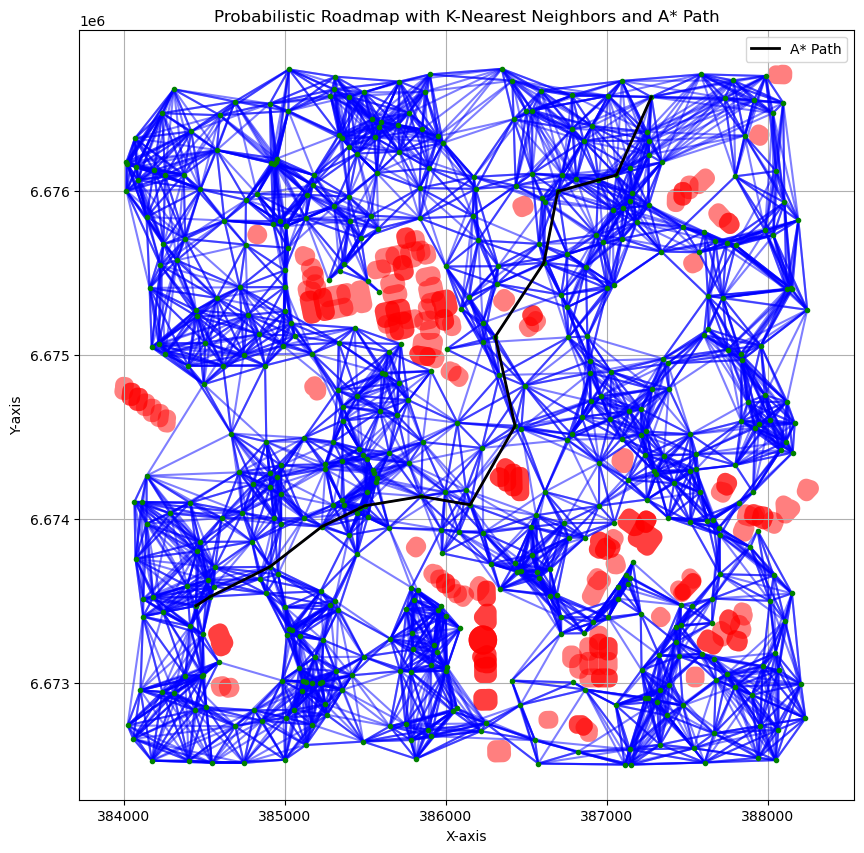

In [838]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon
from scipy.spatial import cKDTree
import geopandas as gpd

# Constants
NUM_NODES = 500  # Total nodes in the roadmap
K_NEIGHBORS = 15  # Number of nearest neighbors for each node
OBSTACLE_CLEARANCE = 10  # Minimum distance from obstacles for node placement
WEIGHT_DISTANCE = 0.2  # Weight for distance in cost calculation
WEIGHT_RISK = 2  # Weight for risk in cost calculation
MAX_DISTANCE = max_distance  # Maximum distance for normalization

# Convert obstacles to a list of polygons
obstacle_polygons = [obs.geometry for _, obs in buffered_obstacles.iterrows()]

# Function to get risk at a specific point (should return normalized risk)
def get_risk_at_point(x, y):
    # Replace this with actual risk retrieval logic
    # Example: return a value based on a risk grid or a dataframe
    return np.random.rand()  # Random risk for demonstration, should be normalized

# PRM Generation with K-nearest neighbors
def generate_prm(start, goal, gdf_selected, obstacle_polygons):
    nodes = [start, goal]
    min_x, min_y, max_x, max_y = gdf_selected.total_bounds

    # Generate random nodes within bounds of gdf_selected avoiding obstacles
    while len(nodes) < NUM_NODES + 2:
        x = np.random.uniform(min_x, max_x)
        y = np.random.uniform(min_y, max_y)
        node = Point(x, y)

        # Check if node is within gdf_selected and clear of obstacles
        if gdf_selected.unary_union.contains(node) and all(obstacle.distance(node) > OBSTACLE_CLEARANCE for obstacle in obstacle_polygons):
            nodes.append((x, y))

    # Create edges with K-nearest neighbors
    kdtree = cKDTree(nodes)
    edges = []
    for i, node in enumerate(nodes):
        # Find the K nearest neighbors for each node
        distances, neighbors = kdtree.query(node, k=K_NEIGHBORS + 1)  # +1 to exclude self in nearest neighbors

        for neighbor_idx in neighbors[1:]:  # Skip the first neighbor (self)
            neighbor = nodes[neighbor_idx]
            line = LineString([node, neighbor])

            # Ensure edge does not intersect obstacles
            if all(not obstacle.intersects(line) for obstacle in obstacle_polygons):
                edges.append((i, neighbor_idx))

    print(f"Generated {len(nodes)} nodes and {len(edges)} edges.")
    return nodes, edges

# A* Pathfinding with weighted cost
def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def edge_cost(node1, node2):
    # Calculate the Euclidean distance
    distance = np.linalg.norm(np.array(node1) - np.array(node2))
    
    # Normalize the distance
    normalized_distance = distance / MAX_DISTANCE
    
    # Get risk values for both nodes
    risk1 = get_risk_at_point(node1[0], node1[1])
    risk2 = get_risk_at_point(node2[0], node2[1])
    
    # Average risk for both nodes
    average_risk = (risk1 + risk2) / 2

    # Combine normalized distance and risk
    combined_cost = (WEIGHT_DISTANCE * normalized_distance + 
                     WEIGHT_RISK * average_risk)
    
    return combined_cost

def a_star(nodes, edges, start, goal):
    start_idx = nodes.index(start)
    goal_idx = nodes.index(goal)

    open_set = {start_idx}
    came_from = {}

    g_score = {i: float('inf') for i in range(len(nodes))}
    g_score[start_idx] = 0
    f_score = {i: float('inf') for i in range(len(nodes))}
    f_score[start_idx] = heuristic(start, goal)

    while open_set:
        current = min(open_set, key=lambda x: f_score[x])
        if current == goal_idx:
            path = []
            while current in came_from:
                path.append(nodes[current])
                current = came_from[current]
            path.append(start)
            print("Path found.")
            return path[::-1]

        open_set.remove(current)

        current_point = nodes[current]
        for edge in edges:
            if current in edge:
                neighbor = edge[1] if edge[0] == current else edge[0]
                tentative_g_score = g_score[current] + edge_cost(current_point, nodes[neighbor])

                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(nodes[neighbor], goal)
                    open_set.add(neighbor)

    print("No path found.")
    return None

# Visualization
def draw_path(nodes, edges, obstacle_polygons, path=None):
    plt.figure(figsize=(10, 10))

    # Plot obstacles
    for obs in obstacle_polygons:
        x, y = obs.exterior.xy
        plt.fill(x, y, 'r', alpha=0.5)

    # Plot nodes and edges
    for edge in edges:
        node1, node2 = nodes[edge[0]], nodes[edge[1]]
        plt.plot([node1[0], node2[0]], [node1[1], node2[1]], 'b-', alpha=0.5)

    for node in nodes:
        plt.plot(node[0], node[1], 'go', markersize=3)

    # Plot path if found
    if path:
        path = np.array(path)
        plt.plot(path[:, 0], path[:, 1], 'black', linewidth=2, label="A* Path")

    plt.legend()
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Probabilistic Roadmap with K-Nearest Neighbors and A* Path")
    plt.grid()
    plt.show()



nodes, edges = generate_prm(start, goal, gdf_selected, obstacle_polygons)
path = a_star(nodes, edges, start, goal)

draw_path(nodes, edges, obstacle_polygons, path)


In [839]:
def calculate_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

# Function to interpolate points between two points every 50 meters
def interpolate_points(point1, point2, interval=50):
    distance = calculate_distance(point1, point2)
    if distance <= interval:
        return []  # No need to interpolate if distance is within the interval
    num_points = int(distance // interval)
    interpolated_points = []
    for i in range(1, num_points + 1):
        t = i * interval / distance
        x = (1 - t) * point1[0] + t * point2[0]
        y = (1 - t) * point1[1] + t * point2[1]
        interpolated_points.append((x, y))
    return interpolated_points

In [840]:
line = LineString(path)

In [841]:
points = resample_line_points(line)

In [842]:
calculate_cumulative_risk(points), total_distance(path)

(6.194310713482472, 4884.380327544926)

In [843]:
risks_prm_a = [16.94706860153256, 3.55461004298554, 12.105702232179024, 5.8509907456430525, 4.7350615383318475]

distances_prm_a = [4671.884556124434, 4596.539784104062, 5398.762964855488, 4637.723709119923, 4860.396923741288]

In [844]:
path_aprm = [Point(node[0], node[1]) for node in points]

In [845]:
len(points)

99

In [846]:
coordinates = [(point.x, point.y) for point in path_aprm]
min_distances = distance_to_obstacles(coordinates, obstacle_coords)
np.mean(min_distances)

340.594294487378

In [847]:
do_aprm=[282.6686908658368, 263.37283892943793, 267.2650589775405, 392.1049676013221, 353.5556705384255]

In [848]:
smoothness_score = calculate_smoothness(coordinates)
print(f"Smoothness Score: {smoothness_score:.2f} degrees")

Smoothness Score: 3.70 degrees


In [849]:
smooth_aprm = [2.97, 3.16, 3.84, ]

Generated 365 nodes and 4972 edges.
Path found.


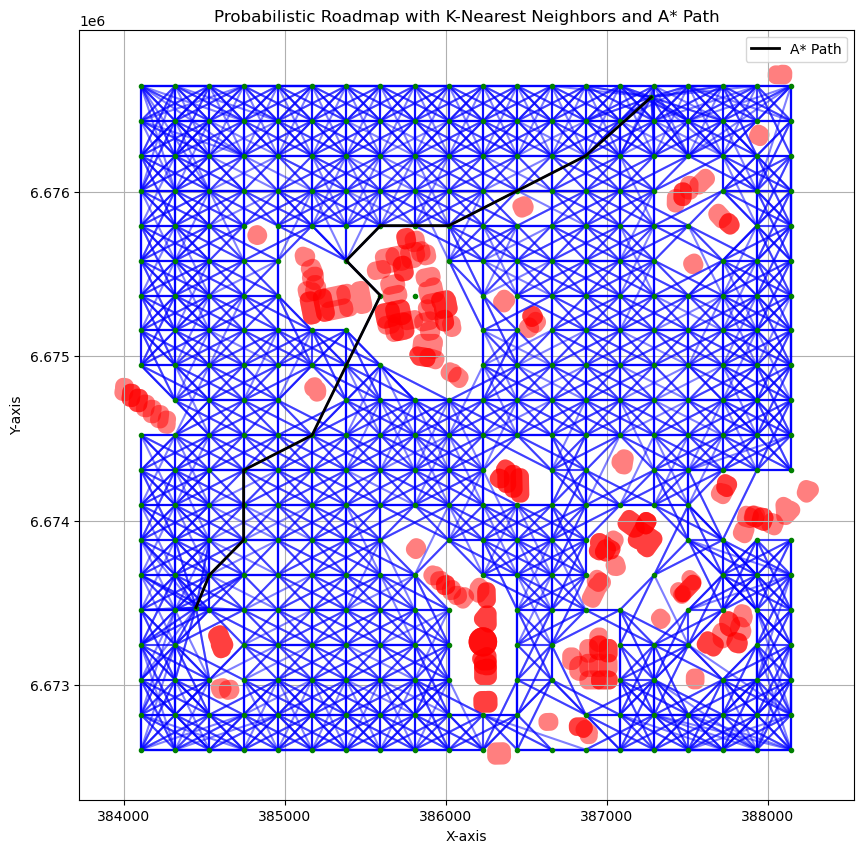

In [850]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from scipy.spatial import cKDTree
import geopandas as gpd

# Constants
K_NEIGHBORS = 15  # Number of nearest neighbors for each node
OBSTACLE_CLEARANCE = 10  # Minimum distance from obstacles for node placement
WEIGHT_DISTANCE = 0.2  # Weight for distance in cost calculation
WEIGHT_RISK = 2  # Weight for risk in cost calculation
GRID_SIZE = 20  # Number of cells per row and column for grid
MAX_DISTANCE = max_distance  # Maximum distance for normalization

# Convert obstacles to a list of polygons
obstacle_polygons = [obs.geometry for _, obs in buffered_obstacles.iterrows()]

# Function to get risk at a specific point (should return normalized risk)
def get_risk_at_point(x, y):
    # Replace this with actual risk retrieval logic
    return np.random.rand()  # Random risk for demonstration, should be normalized

# Generate nodes as centroids of cells in grid
def generate_prm_from_grid(start, goal, gdf_selected, obstacle_polygons):
    nodes = [start, goal]
    min_x, min_y, max_x, max_y = gdf_selected.total_bounds
    cell_width = (max_x - min_x) / GRID_SIZE
    cell_height = (max_y - min_y) / GRID_SIZE

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            x = min_x + (i + 0.5) * cell_width
            y = min_y + (j + 0.5) * cell_height
            node = Point(x, y)

            # Check if node is within bounds and clear of obstacles
            if gdf_selected.unary_union.contains(node) and all(obstacle.distance(node) > OBSTACLE_CLEARANCE for obstacle in obstacle_polygons):
                nodes.append((x, y))

    # Create edges with K-nearest neighbors
    kdtree = cKDTree(nodes)
    edges = []
    for i, node in enumerate(nodes):
        distances, neighbors = kdtree.query(node, k=K_NEIGHBORS + 1)

        for neighbor_idx in neighbors[1:]:  # Skip the first neighbor (self)
            neighbor = nodes[neighbor_idx]
            line = LineString([node, neighbor])

            # Ensure edge does not intersect obstacles
            if all(not obstacle.intersects(line) for obstacle in obstacle_polygons):
                edges.append((i, neighbor_idx))

    print(f"Generated {len(nodes)} nodes and {len(edges)} edges.")
    return nodes, edges

# Visualization
def draw_path(nodes, edges, obstacle_polygons, path=None):
    plt.figure(figsize=(10, 10))

    # Plot obstacles
    for obs in obstacle_polygons:
        x, y = obs.exterior.xy
        plt.fill(x, y, 'r', alpha=0.5)

    # Plot nodes and edges
    for edge in edges:
        node1, node2 = nodes[edge[0]], nodes[edge[1]]
        plt.plot([node1[0], node2[0]], [node1[1], node2[1]], 'b-', alpha=0.5)

    for node in nodes:
        plt.plot(node[0], node[1], 'go', markersize=3)

    # Plot path if found
    if path:
        path = np.array(path)
        plt.plot(path[:, 0], path[:, 1], 'black', linewidth=2, label="A* Path")

    plt.legend()
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Probabilistic Roadmap with K-Nearest Neighbors and A* Path")
    plt.grid()
    plt.show()

# Use modified PRM generation
nodes, edges = generate_prm_from_grid(start, goal, gdf_selected, obstacle_polygons)
path = a_star(nodes, edges, start, goal)

draw_path(nodes, edges, obstacle_polygons, path)

In [851]:
line = LineString(path)

In [852]:
points = resample_line_points(line)

In [853]:
calculate_cumulative_risk(points), total_distance(path)

(13.435328598008452, 4883.966165149604)

In [854]:
risks_a = [13.627122897924956, 4.432895404611036, 12.805326205564556, 13.435328598008452, 6.718672608328192]

distances_a = [4404.908856253046, 4552.494185985191, 4414.26687494937, 4883.966165149604, 4317.87779706798]

In [855]:
path_aa = [Point(node[0], node[1]) for node in points]

In [856]:
coordinates = [(point.x, point.y) for point in path_aa]
min_distances = distance_to_obstacles(coordinates, obstacle_coords)
np.mean(min_distances)

325.53667974071635

In [857]:
do_aa=[221.45652521375118, 313.8136873670612, 270.20586660578925, 325.53667974071635, 376.913468671017]

In [858]:
smoothness_score = calculate_smoothness(coordinates)
print(f"Smoothness Score: {smoothness_score:.2f} degrees")

Smoothness Score: 4.28 degrees


In [859]:
smooth_aa = [2.54, 3.13, 2.29]

In [781]:
do_ddqn = [269.6468652701196, 360.0311114250979, 316.66538244312545, 372.66950110025743, 303.2318832850866]

do_rrt = [244.6099852764946, 264.6692233255112, 292.9318462562203, 375.7613055095711, 345.6226551879867]

do_aprm=[282.6686908658368, 263.37283892943793, 267.2650589775405, 392.1049676013221, 353.5556705384255]

do_aa=[221.45652521375118, 313.8136873670612, 270.20586660578925, 325.53667974071635, 376.913468671017]

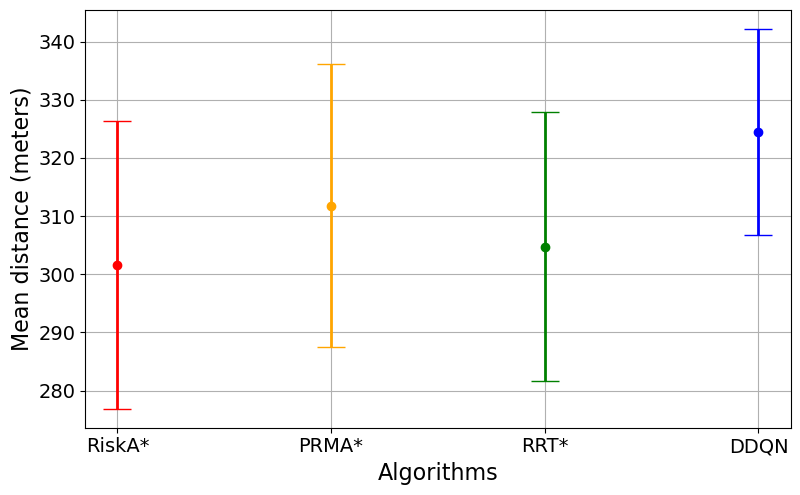

In [892]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Data for each algorithm
do_aa = [221.45652521375118, 313.8136873670612, 270.20586660578925, 325.53667974071635, 376.913468671017]
do_aprm = [282.6686908658368, 263.37283892943793, 267.2650589775405, 392.1049676013221, 353.5556705384255]
do_rrt = [244.6099852764946, 264.6692233255112, 292.9318462562203, 375.7613055095711, 345.6226551879867]

do_ddqn = [269.6468652701196, 360.0311114250979, 316.66538244312545, 372.66950110025743, 303.2318832850866]

# List of algorithms
algorithms = ['RiskA*', 'PRMA*', 'RRT*', 'DDQN']
data = [do_aa, do_aprm, do_rrt, do_ddqn]

# Prepare to plot
colors = ['red', 'orange', 'green', 'blue']
means = [np.mean(d) for d in data]
conf_intervals = [stats.t.interval(0.6, len(d)-1, loc=np.mean(d), scale=stats.sem(d)) for d in data]

# Plot 2: Mean Risks with Confidence Intervals
plt.figure(figsize=(8, 5))  # Adjusted figure size
for i, algorithm in enumerate(algorithms):
    plt.errorbar(algorithm, means[i], 
                 yerr=[[means[i] - conf_intervals[i][0]], [conf_intervals[i][1] - means[i]]], 
                 fmt='o', capsize=10, color=colors[i], label=algorithm, linewidth=2)  # Thinner line
# plt.title('Mean Risks with Confidence Intervals')
plt.xlabel('Algorithms', fontsize=16)
plt.ylabel('Mean distance (meters)', fontsize=16)
plt.grid()
plt.tight_layout()
plt.xticks(fontsize=14)  # X-tick font size
plt.yticks(fontsize=14)
plt.savefig('obstalces.png')
plt.show()


# # Create scatter plot with error bars for confidence intervals
# plt.figure(figsize=(8, 5))
# for i, d in enumerate(data):
#     # Scatter points for each algorithm
# #     plt.scatter([algorithms[i]] * len(d), d, color=colors[i], alpha=0.6, label=algorithms[i])

#     # Plot mean with confidence interval
#     plt.errorbar(algorithms[i], means[i], 
#                  yerr=[[means[i] - conf_intervals[i][0]], [conf_intervals[i][1] - means[i]]],
#                  fmt='o', color=colors[i], capsize=10, markersize=8)

# # Customize plot
# plt.title('Comparison of Path Planning Algorithms')
# plt.xlabel('Algorithms', fontsize=16)
# plt.ylabel('Distance (meters)', fontsize=16)
# plt.grid(True)
# plt.legend(fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.tight_layout()

# # Show plot
# plt.show()


In [588]:
# line = LineString(path_aa)

# # Calculate the Total Curvature
# def total_curvature(line):
#     angles = []
#     for i in range(1, len(line.coords) - 1):
#         p1 = np.array(line.coords[i - 1])
#         p2 = np.array(line.coords[i])
#         p3 = np.array(line.coords[i + 1])
        
#         # Calculate vectors
#         v1 = p2 - p1
#         v2 = p3 - p2
        
#         # Calculate angle between vectors
#         angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
#         angle = np.degrees(angle)  # Convert to degrees
        
#         # Normalize angle to be within 0-360 degrees
#         if angle < 0:
#             angle += 360
        
#         angles.append(angle)
    
#     # Total curvature is the sum of the absolute values of angles
#     return sum(angles)

# # Calculate Path Length
# def path_length(line):
#     return line.length

# # Calculate Total Curvature and Path Length
# curvature = total_curvature(line)
# length = path_length(line)

# # Normalize the Total Curvature to obtain a smoothness index between 0 and 1
# max_curvature = 180 * (len(points) - 2)  # Maximum curvature if all turns are 180 degrees
# path_smoothness_index = 1 - (curvature / max_curvature)

# # Ensure smoothness index is between 0 and 1
# path_smoothness_index = max(0, min(1, path_smoothness_index))

# print(f'Total Curvature: {curvature:.2f} degrees')
# print(f'Path Length: {length:.2f} units')
# print(f'Path Smoothness Index: {path_smoothness_index:.2f} (0: less smooth, 1: more smooth)')

In [347]:
import numpy as np

def distance_to_obstacles(waypoints, obstacles):
    """
    Calculate the minimum distance from each waypoint to the nearest obstacle.

    Parameters:
    - waypoints: List of tuples representing the waypoints (x, y).
    - obstacles: List of tuples representing the obstacles (x, y).

    Returns:
    - distances: List of minimum distances from each waypoint to the nearest obstacle.
    """
    distances = []
    
    for waypoint in waypoints:
        waypoint_array = np.array(waypoint)
        # Calculate the distances from the current waypoint to all obstacles
        obstacle_distances = np.linalg.norm(np.array(obstacles) - waypoint_array, axis=1)
        # Find the minimum distance to any obstacle
        min_distance = np.min(obstacle_distances)
        distances.append(min_distance)
    
    return distances

In [342]:
import numpy as np


def closest_obstacle_distance(waypoint, obstacle_centroids):
    min_distance = float('inf')
    
    # Calculate distance to each obstacle centroid
    for obstacle in obstacle_centroids:
        distance = np.sqrt((waypoint[0] - obstacle[0]) ** 2 + (waypoint[1] - obstacle[1]) ** 2)
        if distance < min_distance:
            min_distance = distance
            
    return min_distance

# Calculate distances for each waypoint
distances = []
for waypoint in coordinates:
    distance = closest_obstacle_distance(waypoint, obstacle_coords)
    distances.append(distance)

# # Output distances
# for i, (waypoint, distance) in enumerate(zip(coordinates, distances)):
#     print(f"Waypoint {i+1} at {waypoint} is {distance:.2f} units away from the nearest obstacle.")
np.min(distances)

79.41190139700281

In [285]:
# import numpy as np
# import matplotlib.pyplot as plt
# from shapely.geometry import Point, LineString, Polygon
# import geopandas as gpd

# # Constants
# NUM_ANTS = 30
# NUM_ITERATIONS = 100
# EVAPORATION_RATE = 0.5
# INITIAL_PHEROMONE = 1.0
# ALPHA = 1.0  # Pheromone importance
# BETA = 2.0   # Heuristic importance (e.g., inverse of distance)

# # Function to calculate distance
# def calculate_distance(node1, node2):
#     return np.linalg.norm(np.array(node1) - np.array(node2))

# # Function to update pheromones
# def update_pheromones(pheromones, paths, costs):
#     pheromones *= (1 - EVAPORATION_RATE)  # Evaporate pheromones
#     for path, cost in zip(paths, costs):
#         for i in range(len(path) - 1):
#             pheromones[path[i]][path[i+1]] += INITIAL_PHEROMONE / cost  # Add pheromone

# # ACO main function
# def ant_colony_optimization(nodes, edges, start, goal):
#     pheromones = np.zeros((len(nodes), len(nodes)))

#     # Initialize pheromones
#     for i in range(len(nodes)):
#         for j in range(len(nodes)):
#             if i != j and (i, j) in edges:
#                 pheromones[i][j] = INITIAL_PHEROMONE

#     best_path = None
#     best_cost = float('inf')

#     for iteration in range(NUM_ITERATIONS):
#         paths = []
#         costs = []

#         for _ in range(NUM_ANTS):
#             path = [nodes.index(start)]
#             while path[-1] != nodes.index(goal):
#                 current = path[-1]
#                 probabilities = []
#                 for next_node in range(len(nodes)):
#                     if (current, next_node) in edges:
#                         pheromone = pheromones[current][next_node]
#                         heuristic = 1 / (calculate_distance(nodes[current], nodes[next_node]) + 1e-10)  # Avoid division by zero
#                         probabilities.append((pheromone ** ALPHA) * (heuristic ** BETA))
#                     else:
#                         probabilities.append(0)

#                 # Normalize probabilities
#                 probabilities = np.array(probabilities) / sum(probabilities)
#                 next_node = np.random.choice(range(len(nodes)), p=probabilities)
#                 path.append(next_node)

#             # Calculate the cost of the path
#             cost = sum(calculate_distance(nodes[path[i]], nodes[path[i+1]]) for i in range(len(path) - 1))
#             paths.append(path)
#             costs.append(cost)

#             # Update best path if necessary
#             if cost < best_cost:
#                 best_cost = cost
#                 best_path = path

#         # Update pheromones after all ants have completed their paths
#         update_pheromones(pheromones, paths, costs)

#         print(f"Iteration {iteration + 1}: Best cost = {best_cost}")

#     return best_path

# # Visualization function
# def draw_path(nodes, edges, obstacle_polygons, path=None):
#     plt.figure(figsize=(10, 10))

#     # Plot obstacles
#     for obs in obstacle_polygons:
#         x, y = obs.exterior.xy
#         plt.fill(x, y, 'r', alpha=0.5)

#     # Plot nodes and edges
#     for edge in edges:
#         node1, node2 = nodes[edge[0]], nodes[edge[1]]
#         plt.plot([node1[0], node2[0]], [node1[1], node2[1]], 'b-', alpha=0.5)

#     for node in nodes:
#         plt.plot(node[0], node[1], 'go', markersize=3)

#     # Plot path if found
#     if path is not None:
#         path_coords = np.array([nodes[i] for i in path])
#         plt.plot(path_coords[:, 0], path_coords[:, 1], 'black', linewidth=2, label="ACO Path")

#     plt.legend()
#     plt.xlabel("X-axis")
#     plt.ylabel("Y-axis")
#     plt.title("Ant Colony Optimization Pathfinding")
#     plt.grid()
#     plt.show()

# # Generate nodes and edges (this can be done similarly to the PRM function)
# nodes, edges = generate_prm_from_grid(start, goal, gdf_selected, obstacle_polygons)  # You can reuse the function for node generation
# path = ant_colony_optimization(nodes, edges, start, goal)

# draw_path(nodes, edges, obstacle_polygons, path)


In [899]:
# from IPython.display import clear_output
# import matplotlib.pyplot as plt
# import geopandas as gpd
# import numpy as np
# from shapely.geometry import Point

# def render(gdf_visibility, buffered_obstacles, gdf_selected, path_rrt=None, path_a_star=None, path_aprm=None, path_drl=None, path_genetic=None, target_position=None, waypoints=None):
#     fig, ax_left = plt.subplots(figsize=(10, 10))

#     # Plot the main map components
# #     buffered_obstacles.plot(ax=ax_left, color='red', alpha=1, label='Obstacles with Safety Buffer')

#     # Calculate risk values for each grid cell based on its centroid
#     risk_values = []
#     for geom in gdf_selected.geometry:
#         centroid = geom.centroid
#         risk = get_risk(work_gdf_normalized, centroid, time_to_interval(time))
#         risk_values.append(risk)

#     # Normalize risk values for color mapping (0-1 range)
#     max_risk = max(risk_values) if risk_values else 1  # Avoid division by zero
#     min_risk = min(risk_values) if risk_values else 0
#     normalized_risks = [(r - min_risk) / (max_risk - min_risk) if max_risk > min_risk else 0 for r in risk_values]

#     # Create a colormap
#     cmap = plt.cm.Reds  # You can choose other colormaps like plt.cm.viridis, plt.cm.plasma, etc.

#     # Plot grid cells with color based on risk
#     for i, (geom, risk) in enumerate(zip(gdf_selected.geometry, normalized_risks)):
#         color = cmap(risk)  # Get color based on normalized risk value
#         ax_left.add_patch(plt.Rectangle((geom.bounds[0], geom.bounds[1]), geom.bounds[2] - geom.bounds[0], geom.bounds[3] - geom.bounds[1], color=color, alpha=1))

#     # Plot the grid boundaries
#     gdf_selected.boundary.plot(ax=ax_left, color='black', linewidth=1, label='')

#     # Helper function to plot individual paths
#     def plot_path(path, color, label):
#         x_path = [point.x for point in path]
#         y_path = [point.y for point in path]
#         ax_left.plot(x_path, y_path, color=color, linewidth=3, label=label)
        

#     start_point = path_drl[0]    
#     buffered_obstacles.plot(ax=ax_left, color='black', alpha=1, label='Obstacles with Safety Buffer')
#     ax_left.plot(start_point.x, start_point.y, 'go', markersize=10, label='Start Point')
#     if target_position is not None:
#         ax_left.scatter(target_position.x, target_position.y, c='red', marker='^', s=300, label='Target Point')
            
#     # Plot each algorithm's path if provided
#     if path_rrt is not None:
#         plot_path(path_rrt, 'green', 'RRT*')
#     if path_a_star is not None:
#         plot_path(path_a_star, 'red', 'RiskA*')
#     if path_aprm is not None:
#         plot_path(path_aprm, 'orange', 'PRMA*')
#     if path_drl is not None:
#         plot_path(path_drl, 'blue', 'DDQN')
# #     if path_genetic is not None:
# #         plot_path(path_genetic, 'magenta', 'Genetic Path')

#     # Set up the main plot's title and legend
# #     ax_left.set_title("Visibility Graph with Grid Connections and Safety Distance", fontsize=15)
#     ax_left.legend(loc='upper right', fontsize=14)
#     ax_left.grid(True)

#     clear_output(wait=True)
#     plt.tight_layout()
#     plt.xticks(fontsize=14)  # X-tick font size
#     plt.yticks(fontsize=14)
#     plt.savefig('paths_plot.png')
#     plt.show()


In [900]:
time=24300+10*45


In [933]:
# from IPython.display import clear_output
# import matplotlib.pyplot as plt
# import geopandas as gpd
# import numpy as np
# from shapely.geometry import Point

# def render(gdf_visibility, buffered_obstacles, gdf_selected, path_rrt=None, path_a_star=None, path_aprm=None, path_drl=None, path_genetic=None, target_position=None, waypoints=None):
#     fig, ax_left = plt.subplots(figsize=(10, 10))

#     # Calculate risk values for each grid cell based on its centroid
#     risk_values = []
#     for geom in gdf_selected.geometry:
#         centroid = geom.centroid
#         risk = get_risk(work_gdf_normalized, centroid, time_to_interval(time))
#         risk_values.append(risk)

#     # Normalize risk values for color mapping (0-1 range)
#     max_risk = max(risk_values) if risk_values else 1
#     min_risk = min(risk_values) if risk_values else 0
#     normalized_risks = [(r - min_risk) / (max_risk - min_risk) if max_risk > min_risk else 0 for r in risk_values]

#     # Create a colormap
#     cmap = plt.cm.Reds

#     # Plot grid cells with color based on risk
#     for i, (geom, risk) in enumerate(zip(gdf_selected.geometry, normalized_risks)):
#         color = cmap(risk)
#         ax_left.add_patch(plt.Rectangle((geom.bounds[0], geom.bounds[1]), geom.bounds[2] - geom.bounds[0], geom.bounds[3] - geom.bounds[1], color=color, alpha=1))

#     # Plot the grid boundaries
#     gdf_selected.boundary.plot(ax=ax_left, color='black', linewidth=1, label='')

#     # Helper function to plot individual paths
#     def plot_path(path, color, label):
#         x_path = [point.x for point in path]
#         y_path = [point.y for point in path]
#         ax_left.plot(x_path, y_path, color=color, linewidth=3, label=label)

#     start_point = path_drl[0]    
#     buffered_obstacles.plot(ax=ax_left, color='black', alpha=1, label='Obstacles')
#     ax_left.plot([], [], color='black', label='Obstacles')
    
            
#     # Plot each algorithm's path if provided
#     if path_rrt is not None:
#         plot_path(path_rrt, 'green', 'RRT*')
#     if path_a_star is not None:
#         plot_path(path_a_star, 'red', 'RiskA*')
#     if path_aprm is not None:
#         plot_path(path_aprm, 'orange', 'PRMA*')
#     if path_drl is not None:
#         plot_path(path_drl, 'blue', 'DDQN')
# #     if path_genetic is not None:
# #         plot_path(path_genetic, 'magenta', 'Genetic Path')

#     # Set up the main plot's legend
    
    
    
#     ax_left.plot(start_point.x, start_point.y, 'go', markersize=20, label='Start position')
#     if target_position is not None:
#         ax_left.scatter(target_position.x, target_position.y, c='red', marker='^', s=400, label='Final position')
        
#     ax_left.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fontsize=14)
#     ax_left.grid(True)

#     clear_output(wait=True)
# #     plt.tight_layout()
#     plt.xlabel('X', fontsize=18)
#     plt.ylabel('Y', fontsize=18, rotation=0)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.tight_layout()
    
#     plt.savefig('paths_plot.png')
#     plt.show()


In [948]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib as mpl  # Import for ScalarMappable and color bar

def render(gdf_visibility, buffered_obstacles, gdf_selected, path_rrt=None, path_a_star=None, path_aprm=None, path_drl=None, path_genetic=None, target_position=None, waypoints=None):
    fig, ax_left = plt.subplots(figsize=(10, 10))

    # Calculate risk values for each grid cell based on its centroid
    risk_values = []
    for geom in gdf_selected.geometry:
        centroid = geom.centroid
        risk = get_risk(work_gdf_normalized, centroid, time_to_interval(time))
        risk_values.append(risk)

    # Normalize risk values for color mapping (0-1 range)
    max_risk = max(risk_values) if risk_values else 1
    min_risk = min(risk_values) if risk_values else 0
    normalized_risks = [(r - min_risk) / (max_risk - min_risk) if max_risk > min_risk else 0 for r in risk_values]

    # Create a colormap
    cmap = plt.cm.Reds

    # Plot grid cells with color based on risk
    for i, (geom, risk) in enumerate(zip(gdf_selected.geometry, normalized_risks)):
        color = cmap(risk)
        ax_left.add_patch(plt.Rectangle((geom.bounds[0], geom.bounds[1]), geom.bounds[2] - geom.bounds[0], geom.bounds[3] - geom.bounds[1], color=color, alpha=1))

    # Add a color bar for population density (risk)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=min_risk, vmax=max_risk))
    sm.set_array([])  # Dummy data for the color bar
    cbar = plt.colorbar(sm, ax=ax_left, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Population density", fontsize=16)

    # Plot the grid boundaries
    gdf_selected.boundary.plot(ax=ax_left, color='black', linewidth=1)

    # Helper function to plot individual paths
    def plot_path(path, color, label):
        x_path = [point.x for point in path]
        y_path = [point.y for point in path]
        ax_left.plot(x_path, y_path, color=color, linewidth=3, label=label)

    # Plot obstacles as black circles using centroids of polygons, with a single legend entry
#     obstacle_coords = [(polygon.centroid.x, polygon.centroid.y) for polygon in buffered_obstacles.geometry]
#     for i, (x, y) in enumerate(obstacle_coords):
#         if i == 0:  # Add label only for the first obstacle
#             ax_left.scatter(x, y, color='black', s=400, label='Obstacles')  # s=400 for circle size similar to start position
#         else:
#             ax_left.scatter(x, y, color='black', s=400)  # No label for additional obstacles


    # Plot each algorithm's path if provided
    if path_rrt is not None:
        plot_path(path_rrt, 'green', 'RRT*')
    if path_a_star is not None:
        plot_path(path_a_star, 'red', 'RiskA*')
    if path_aprm is not None:
        plot_path(path_aprm, 'orange', 'PRMA*')
    if path_drl is not None:
        plot_path(path_drl, 'blue', 'DDQN')

    # Plot start and target points
    start_point = path_drl[0] if path_drl else None
    if start_point:
        ax_left.plot(start_point.x, start_point.y, 'go', markersize=20, label='Start position')
    if target_position is not None:
        ax_left.scatter(target_position.x, target_position.y, c='red', marker='^', s=400, label='Final position')

    obstacle_coords = [(polygon.centroid.x, polygon.centroid.y) for polygon in buffered_obstacles.geometry]
    for i, (x, y) in enumerate(obstacle_coords):
        if i == 0:  # Add label only for the first obstacle
            ax_left.scatter(x, y, color='black', s=400, label='Obstacles')  # s=400 for circle size similar to start position
        else:
            ax_left.scatter(x, y, color='black', s=400)  # No label for additional obstacles

        
    # Set up the main plot's legend
    ax_left.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=4, fontsize=14)
    ax_left.grid(True)

    clear_output(wait=True)
    plt.xlabel('X', fontsize=18)
    plt.ylabel('Y', fontsize=18, rotation=0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    plt.savefig('paths_plot.png')
    plt.show()


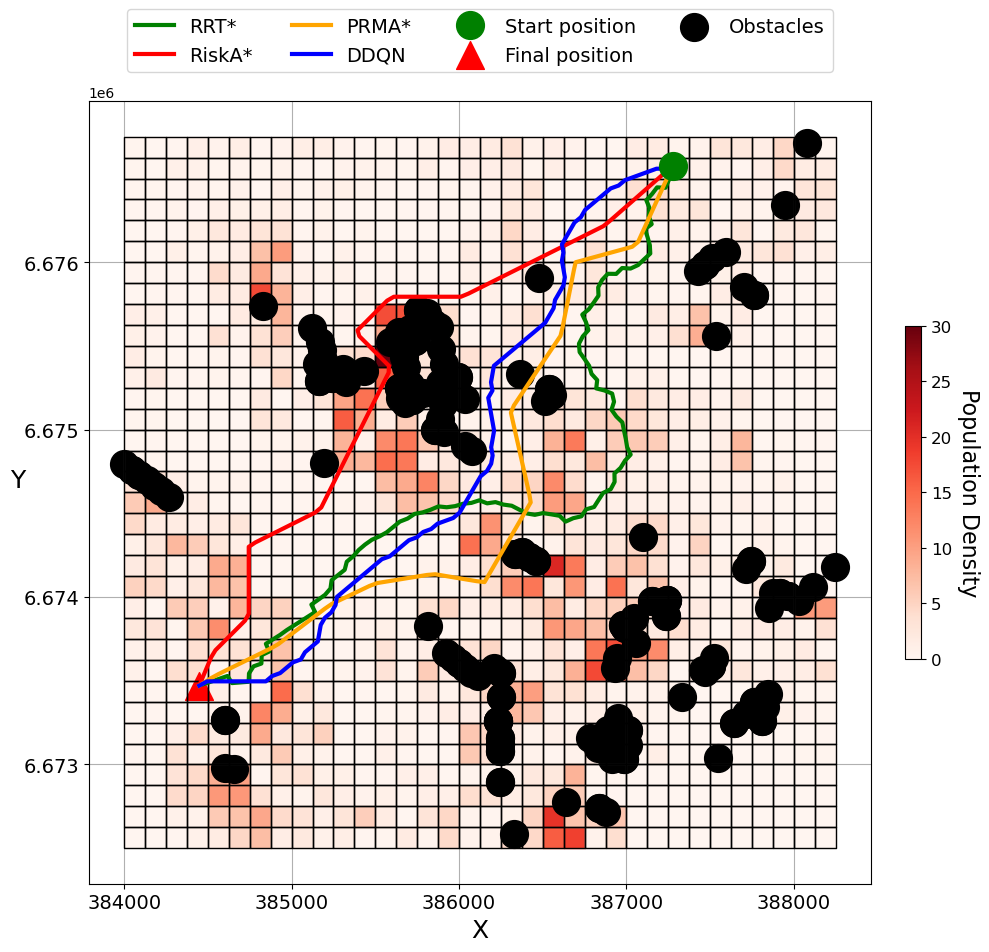

In [971]:
render(None, buffered_obstacles, gdf_selected, path_rrt=point_list, path_a_star=path_aa, path_aprm=path_aprm, path_drl=positions, path_genetic=None, target_position=Point(goal[0], goal[1]))

In [970]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib as mpl  # Import for ScalarMappable and color bar

def render(gdf_visibility, buffered_obstacles, gdf_selected, path_rrt=None, path_a_star=None, path_aprm=None, path_drl=None, path_genetic=None, target_position=None, waypoints=None):
    fig, ax_left = plt.subplots(figsize=(10, 10))

    # Calculate risk values for each grid cell based on its centroid
    risk_values = []
    for geom in gdf_selected.geometry:
        centroid = geom.centroid
        risk = get_risk(work_gdf_normalized, centroid, time_to_interval(time))
        risk_values.append(risk)

    # Normalize and scale risk values for color mapping (0-100 range)
    max_risk = max(risk_values) if risk_values else 1
    min_risk = min(risk_values) if risk_values else 0
    normalized_risks = [(r - min_risk) / (max_risk - min_risk) * 30 if max_risk > min_risk else 0 for r in risk_values]

    # Create a colormap
    cmap = plt.cm.Reds

    # Plot grid cells with color based on risk
    for i, (geom, risk) in enumerate(zip(gdf_selected.geometry, normalized_risks)):
        color = cmap(risk / 30)  # Normalize back to [0, 1] for colormap
        ax_left.add_patch(plt.Rectangle((geom.bounds[0], geom.bounds[1]), geom.bounds[2] - geom.bounds[0], geom.bounds[3] - geom.bounds[1], color=color, alpha=1))

    # Add a color bar for population density (risk)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=30))
    sm.set_array([])  # Dummy data for the color bar
    cbar = plt.colorbar(sm, ax=ax_left, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Population Density", fontsize=16, rotation=270, labelpad=20)
    cbar.ax.tick_params(labelsize=12)

    # Plot the grid boundaries
    gdf_selected.boundary.plot(ax=ax_left, color='black', linewidth=1)

    # Helper function to plot individual paths
    def plot_path(path, color, label):
        x_path = [point.x for point in path]
        y_path = [point.y for point in path]
        ax_left.plot(x_path, y_path, color=color, linewidth=3, label=label)

#     # Plot obstacles as black circles using centroids of polygons, with a single legend entry
#     obstacle_coords = [(polygon.centroid.x, polygon.centroid.y) for polygon in buffered_obstacles.geometry]
#     for i, (x, y) in enumerate(obstacle_coords):
#         if i == 0:  # Add label only for the first obstacle
#             ax_left.scatter(x, y, color='black', s=400, label='Obstacles')  # s=400 for circle size similar to start position
#         else:
#             ax_left.scatter(x, y, color='black', s=400)  # No label for additional obstacles

    # Plot each algorithm's path if provided
    if path_rrt is not None:
        plot_path(path_rrt, 'green', 'RRT*')
    if path_a_star is not None:
        plot_path(path_a_star, 'red', 'RiskA*')
    if path_aprm is not None:
        plot_path(path_aprm, 'orange', 'PRMA*')
    if path_drl is not None:
        plot_path(path_drl, 'blue', 'DDQN')

    # Plot start and target points
    start_point = path_drl[0] if path_drl else None
    if start_point:
        ax_left.plot(start_point.x, start_point.y, 'go', markersize=20, label='Start position')
    if target_position is not None:
        ax_left.scatter(target_position.x, target_position.y, c='red', marker='^', s=400, label='Final position')

    # Plot obstacles as black circles using centroids of polygons, with a single legend entry
    obstacle_coords = [(polygon.centroid.x, polygon.centroid.y) for polygon in buffered_obstacles.geometry]
    for i, (x, y) in enumerate(obstacle_coords):
        if i == 0:  # Add label only for the first obstacle
            ax_left.scatter(x, y, color='black', s=400, label='Obstacles')  # s=400 for circle size similar to start position
        else:
            ax_left.scatter(x, y, color='black', s=400)  # No label for additional obstacles

        
    # Set up the main plot's legend
    ax_left.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=4, fontsize=14)
    ax_left.grid(True)

    clear_output(wait=True)
    plt.xlabel('X', fontsize=18)
    plt.ylabel('Y', fontsize=18, rotation=0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    plt.savefig('paths_plot.png')
    plt.show()


In [ ]:
risks_ddqn = [4.836797178194755, 7.591760962199473, 4.72637198312985, 3.314859428782957, 2.8987285008508863, 
             3.2843445321778937, 5.483107058783845, 3.4403088659128205, 2.752135657194325, 3.5658052201326407]

distances_ddqn = [2224.0532773475866, 2550, 3100, 2537.8561294254055, 2370.063860961228, 
                 2282.217997428716, 2646.299396915387, 2675.96621672971, 2452.1110511536867, 2273.9722626349385]


risks_rrt = [7.855452657651753, 6.7257816651155995, 8.39079306350151, 8.744888698411348, 8.839150522634819,
            3.4227431398269332, 9.428602772204547, 5.290233455898676, 11.04169665109954, 5.996328593163012]

distances_rrt = [2599.282142313216, 2400.0000000024493, 3083.9709096670836, 2768.810243119987, 2449.999999997271,
                2349.9999999992247, 3100.0000000010823, 3100.00000000105, 3093.950338959597, 2980.677308234364]


risks_prm_a = [7.04993258409576, 9.875031821708367, 7.128086073506852, 8.536153979109134, 8.3081101766936,
              3.002651540719433, 7.517149369663367, 6.358730400858347, 9.281408657594808, 3.56359249645977]

distances_prm_a = [2345.5060397904826, 2766.531653557476, 2851.8248404443516, 2268.9969012635606, 2281.8866168720397,
                  2352.2111579323782, 2693.1939522003336, 2873.566060922692, 2379.7775088259073, 2309.4395671581856]


risks_a = [5.710626080191626, 8.289957806719931, 5.800486384010251, 7.768927334139387, 8.112671775431782, 
          4.123760017331941, 6.314555654699315, 12.424493191718394, 2240.197539888921, 2130.015230810907]

distances_a = [2355.4759767882133, 2606.3731259442425, 2667.1578707031113, 2298.308543195912, 2195.3126982168346, 
              2203.0730679806315, 2425.48248987892, 2669.2621452793323, 8.258188491001038, 4.078510258258037]

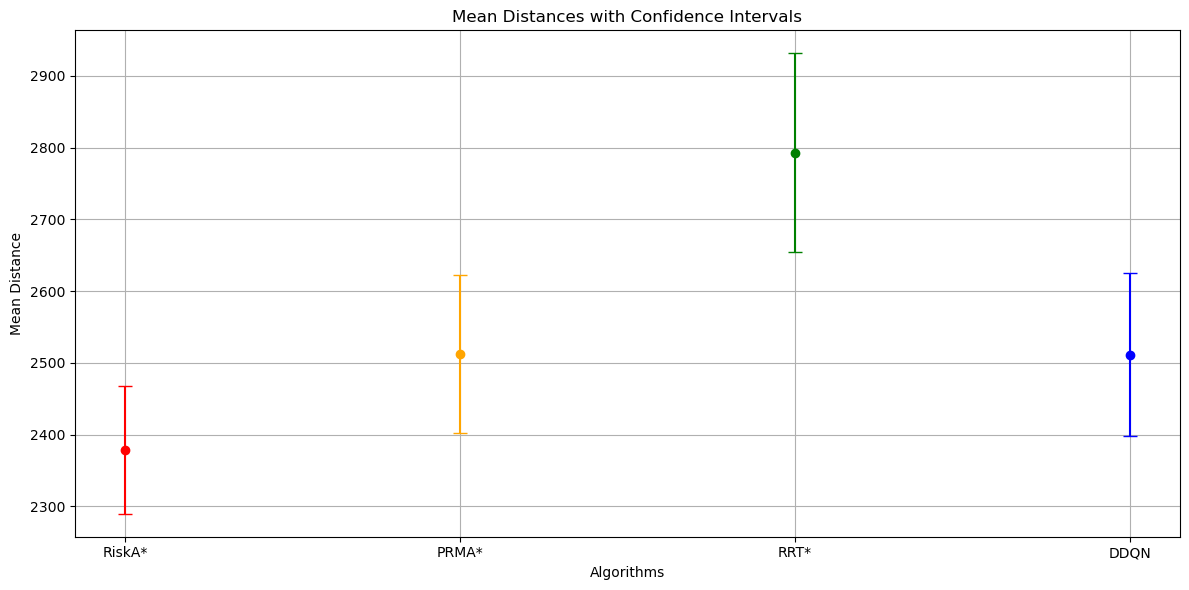

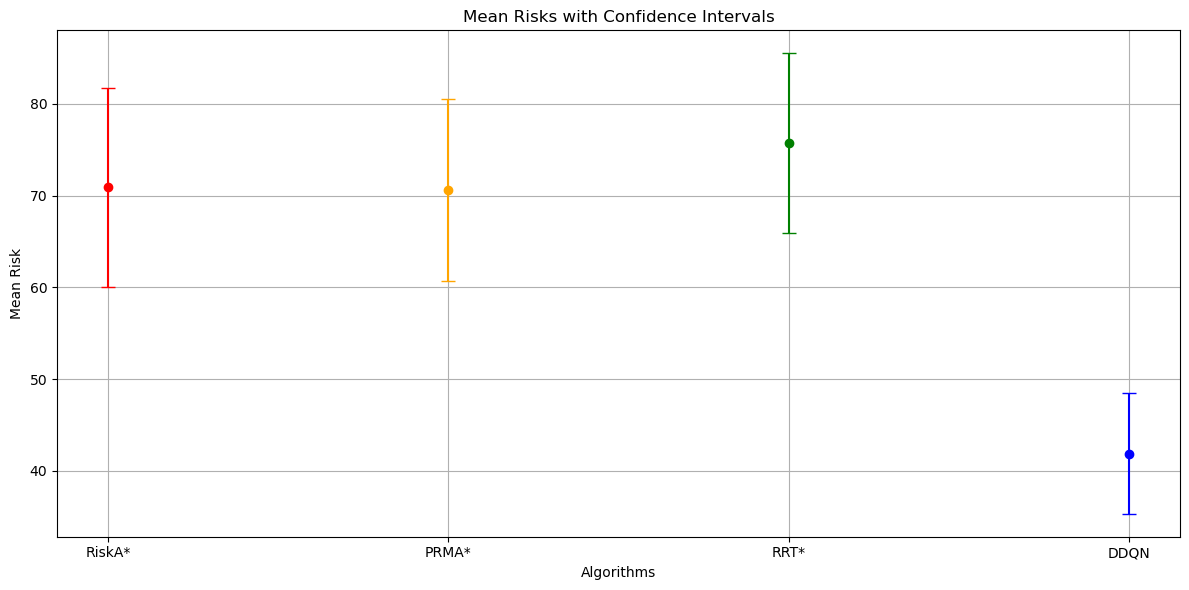

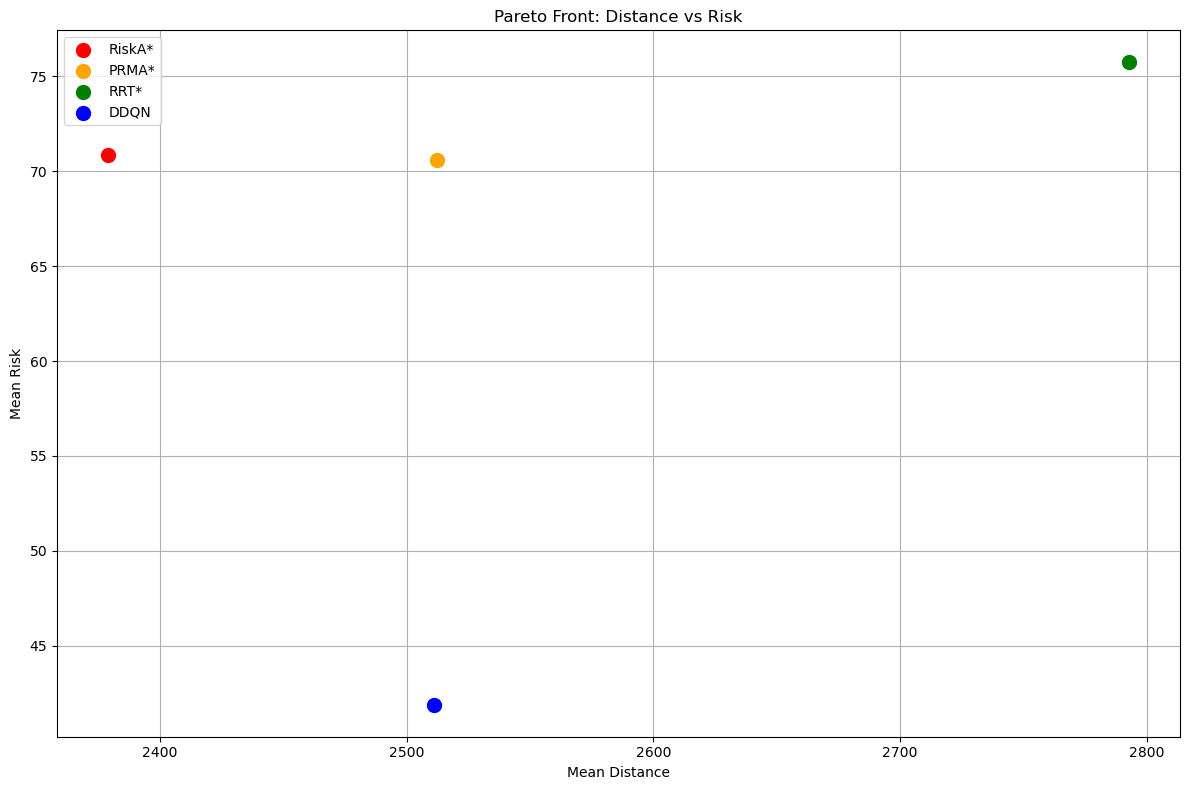

In [305]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Data preparation (same as your initial data)
risks_ddqn = [4.836797178194755, 7.591760962199473, 4.72637198312985, 3.314859428782957, 2.8987285008508863, 
              3.2843445321778937, 5.483107058783845, 3.4403088659128205, 2.752135657194325, 3.5658052201326407]

distances_ddqn = [2224.0532773475866, 2550, 3100, 2537.8561294254055, 2370.063860961228, 
                  2282.217997428716, 2646.299396915387, 2675.96621672971, 2452.1110511536867, 2273.9722626349385]

risks_rrt = [7.855452657651753, 6.7257816651155995, 8.39079306350151, 8.744888698411348, 8.839150522634819,
             3.4227431398269332, 9.428602772204547, 5.290233455898676, 11.04169665109954, 5.996328593163012]

distances_rrt = [2599.282142313216, 2400.0000000024493, 3083.9709096670836, 2768.810243119987, 2449.999999997271,
                 2349.9999999992247, 3100.0000000010823, 3100.00000000105, 3093.950338959597, 2980.677308234364]

risks_prm_a = [7.04993258409576, 9.875031821708367, 7.128086073506852, 8.536153979109134, 8.3081101766936,
               3.002651540719433, 7.517149369663367, 6.358730400858347, 9.281408657594808, 3.56359249645977]

distances_prm_a = [2345.5060397904826, 2766.531653557476, 2851.8248404443516, 2268.9969012635606, 2281.8866168720397,
                   2352.2111579323782, 2693.1939522003336, 2873.566060922692, 2379.7775088259073, 2309.4395671581856]

risks_a = [5.710626080191626, 8.289957806719931, 5.800486384010251, 7.768927334139387, 8.112671775431782, 
           4.123760017331941, 6.314555654699315, 12.424493191718394, 8.258188491001038, 4.078510258258037]

distances_a = [2355.4759767882133, 2606.3731259442425, 2667.1578707031113, 2298.308543195912, 2195.3126982168346, 
               2203.0730679806315, 2425.48248987892, 2669.2621452793323, 2240.197539888921, 2130.015230810907]

# Multiply risks by 10 for visualization
risks = [[risk * 10 for risk in risks_a], [risk * 10 for risk in risks_prm_a], 
         [risk * 10 for risk in risks_rrt], [risk * 10 for risk in risks_ddqn]]
distances = [distances_a, distances_prm_a, distances_rrt, distances_ddqn]
algorithms = ['RiskA*', 'PRMA*', 'RRT*', 'DDQN']
colors = ['red', 'orange', 'green', 'blue']  # Colors for each algorithm

# Function to calculate mean and confidence intervals with lower confidence level
def calculate_confidence_interval(data, confidence=0.8):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    margin_of_error = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)
    return mean, mean - margin_of_error, mean + margin_of_error

# Prepare data for plotting
risk_means, risk_cis, distance_means, distance_cis = [], [], [], []

# Calculate means and confidence intervals
for risk_set, distance_set in zip(risks, distances):
    risk_mean, risk_ci_lower, risk_ci_upper = calculate_confidence_interval(risk_set)
    distance_mean, distance_ci_lower, distance_ci_upper = calculate_confidence_interval(distance_set)
    
    risk_means.append(risk_mean)
    risk_cis.append((risk_ci_lower, risk_ci_upper))
    
    distance_means.append(distance_mean)
    distance_cis.append((distance_ci_lower, distance_ci_upper))

# Plot 1: Mean Distances with Confidence Intervals
plt.figure(figsize=(12, 6))
for i, algorithm in enumerate(algorithms):
    plt.errorbar(algorithm, distance_means[i], 
                 yerr=[[distance_means[i] - distance_cis[i][0]], [distance_cis[i][1] - distance_means[i]]], 
                 fmt='o', capsize=5, color=colors[i], label=algorithm)
plt.title('Mean Distances with Confidence Intervals')
plt.xlabel('Algorithms')
plt.ylabel('Mean Distance')
plt.grid()
plt.tight_layout()
plt.show()

# Plot 2: Mean Risks with Confidence Intervals
plt.figure(figsize=(12, 6))
for i, algorithm in enumerate(algorithms):
    plt.errorbar(algorithm, risk_means[i], 
                 yerr=[[risk_means[i] - risk_cis[i][0]], [risk_cis[i][1] - risk_means[i]]], 
                 fmt='o', capsize=5, color=colors[i], label=algorithm)
plt.title('Mean Risks with Confidence Intervals')
plt.xlabel('Algorithms')
plt.ylabel('Mean Risk')
plt.grid()
plt.tight_layout()
plt.show()

# Plot 3: Pareto Front (Distance vs Risk)
plt.figure(figsize=(12, 8))
for i, algorithm in enumerate(algorithms):
    plt.scatter(distance_means[i], risk_means[i], color=colors[i], s=100, label=algorithm)
plt.title('Pareto Front: Distance vs Risk')
plt.xlabel('Mean Distance')
plt.ylabel('Mean Risk')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('results_2km.png')
plt.show()


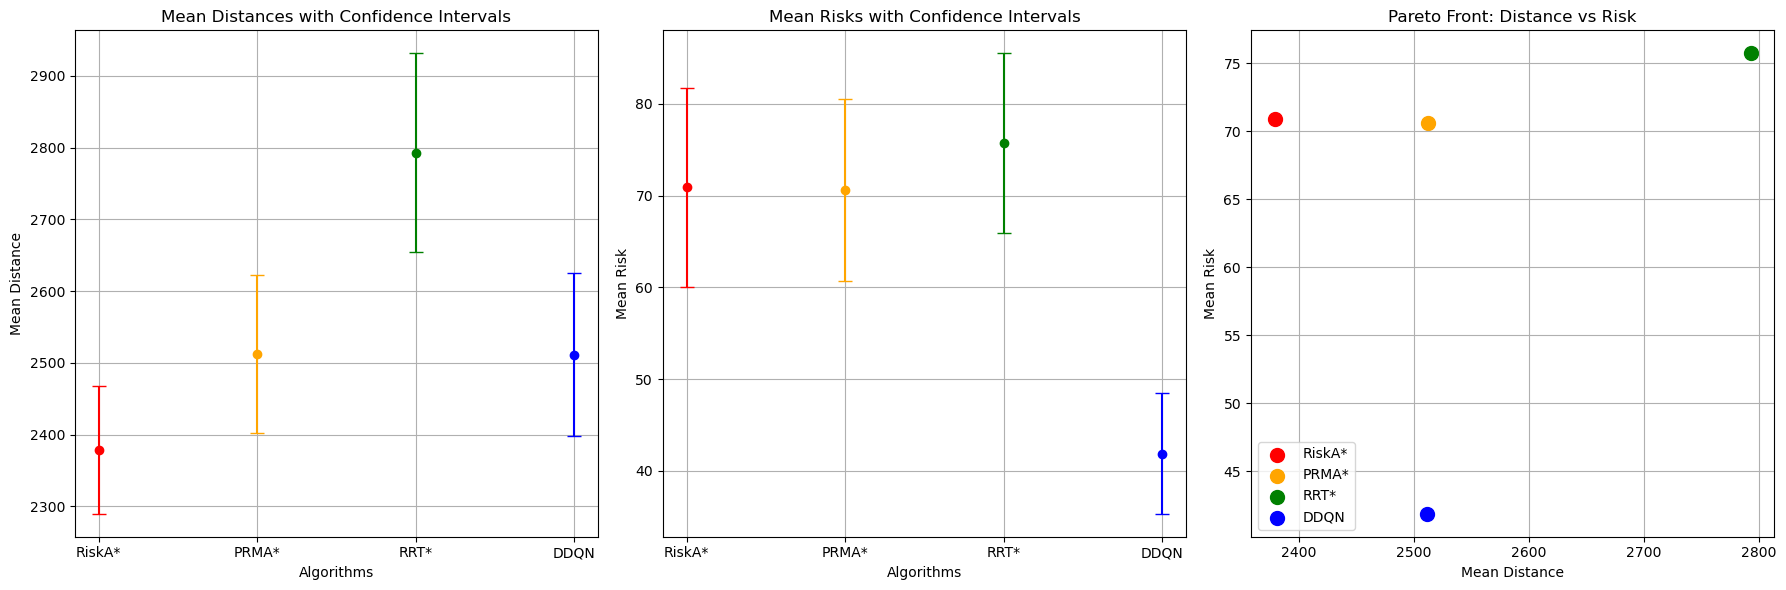

In [312]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Data preparation
risks_ddqn = [4.836797178194755, 7.591760962199473, 4.72637198312985, 3.314859428782957, 2.8987285008508863, 
              3.2843445321778937, 5.483107058783845, 3.4403088659128205, 2.752135657194325, 3.5658052201326407]

distances_ddqn = [2224.0532773475866, 2550, 3100, 2537.8561294254055, 2370.063860961228, 
                  2282.217997428716, 2646.299396915387, 2675.96621672971, 2452.1110511536867, 2273.9722626349385]

risks_rrt = [7.855452657651753, 6.7257816651155995, 8.39079306350151, 8.744888698411348, 8.839150522634819,
             3.4227431398269332, 9.428602772204547, 5.290233455898676, 11.04169665109954, 5.996328593163012]

distances_rrt = [2599.282142313216, 2400.0000000024493, 3083.9709096670836, 2768.810243119987, 2449.999999997271,
                 2349.9999999992247, 3100.0000000010823, 3100.00000000105, 3093.950338959597, 2980.677308234364]

risks_prm_a = [7.04993258409576, 9.875031821708367, 7.128086073506852, 8.536153979109134, 8.3081101766936,
               3.002651540719433, 7.517149369663367, 6.358730400858347, 9.281408657594808, 3.56359249645977]

distances_prm_a = [2345.5060397904826, 2766.531653557476, 2851.8248404443516, 2268.9969012635606, 2281.8866168720397,
                   2352.2111579323782, 2693.1939522003336, 2873.566060922692, 2379.7775088259073, 2309.4395671581856]

risks_a = [5.710626080191626, 8.289957806719931, 5.800486384010251, 7.768927334139387, 8.112671775431782, 
           4.123760017331941, 6.314555654699315, 12.424493191718394, 8.258188491001038, 4.078510258258037]

distances_a = [2355.4759767882133, 2606.3731259442425, 2667.1578707031113, 2298.308543195912, 2195.3126982168346, 
               2203.0730679806315, 2425.48248987892, 2669.2621452793323, 2240.197539888921, 2130.015230810907]

# Multiply risks by 10 for visualization
risks = [[risk * 10 for risk in risks_a], [risk * 10 for risk in risks_prm_a], 
         [risk * 10 for risk in risks_rrt], [risk * 10 for risk in risks_ddqn]]
distances = [distances_a, distances_prm_a, distances_rrt, distances_ddqn]
algorithms = ['RiskA*', 'PRMA*', 'RRT*', 'DDQN']
colors = ['red', 'orange', 'green', 'blue']  # Colors for each algorithm

# Function to calculate mean and confidence intervals with lower confidence level
def calculate_confidence_interval(data, confidence=0.8):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    margin_of_error = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)
    return mean, mean - margin_of_error, mean + margin_of_error

# Prepare data for plotting
risk_means, risk_cis, distance_means, distance_cis = [], [], [], []

# Calculate means and confidence intervals
for risk_set, distance_set in zip(risks, distances):
    risk_mean, risk_ci_lower, risk_ci_upper = calculate_confidence_interval(risk_set)
    distance_mean, distance_ci_lower, distance_ci_upper = calculate_confidence_interval(distance_set)
    
    risk_means.append(risk_mean)
    risk_cis.append((risk_ci_lower, risk_ci_upper))
    
    distance_means.append(distance_mean)
    distance_cis.append((distance_ci_lower, distance_ci_upper))

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Mean Distances with Confidence Intervals
for i, algorithm in enumerate(algorithms):
    ax1.errorbar(algorithm, distance_means[i], 
                 yerr=[[distance_means[i] - distance_cis[i][0]], [distance_cis[i][1] - distance_means[i]]], 
                 fmt='o', capsize=5, color=colors[i], label=algorithm)
ax1.set_title('Mean Distances with Confidence Intervals')
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Mean Distance')
ax1.grid()

# Plot 2: Mean Risks with Confidence Intervals
for i, algorithm in enumerate(algorithms):
    ax2.errorbar(algorithm, risk_means[i], 
                 yerr=[[risk_means[i] - risk_cis[i][0]], [risk_cis[i][1] - risk_means[i]]], 
                 fmt='o', capsize=5, color=colors[i], label=algorithm)
ax2.set_title('Mean Risks with Confidence Intervals')
ax2.set_xlabel('Algorithms')
ax2.set_ylabel('Mean Risk')
ax2.grid()

# Plot 3: Pareto Front (Distance vs Risk)
for i, algorithm in enumerate(algorithms):
    ax3.scatter(distance_means[i], risk_means[i], color=colors[i], s=100, label=algorithm)
ax3.set_title('Pareto Front: Distance vs Risk')
ax3.set_xlabel('Mean Distance')
ax3.set_ylabel('Mean Risk')
ax3.grid()
ax3.legend()

# Display the combined plot
plt.tight_layout()
plt.savefig('results_2km.png')
plt.show()


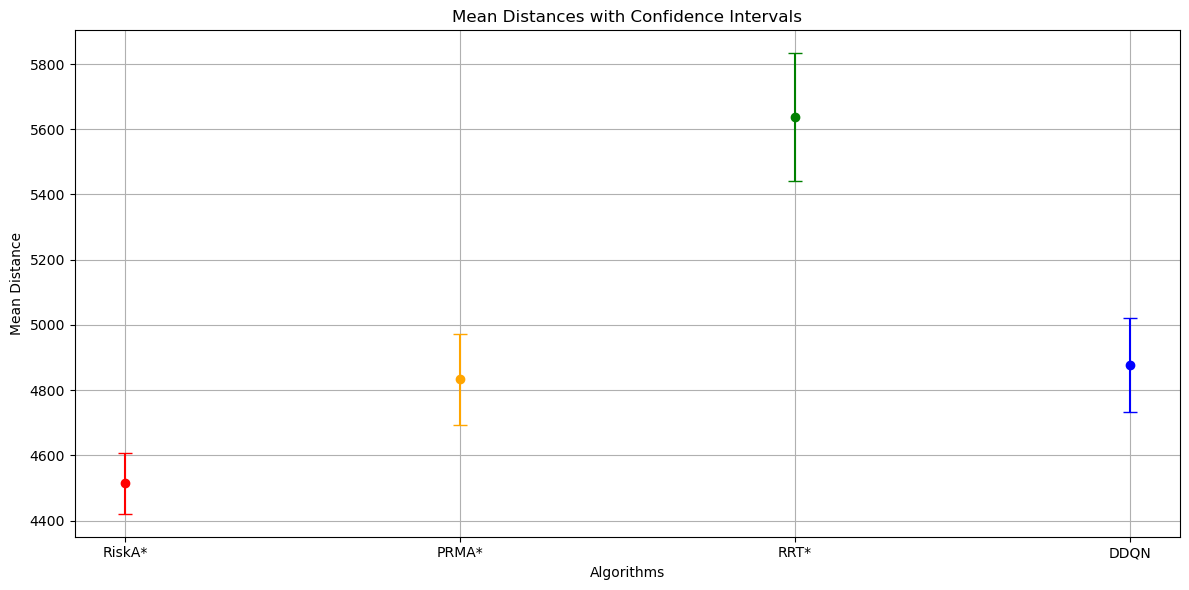

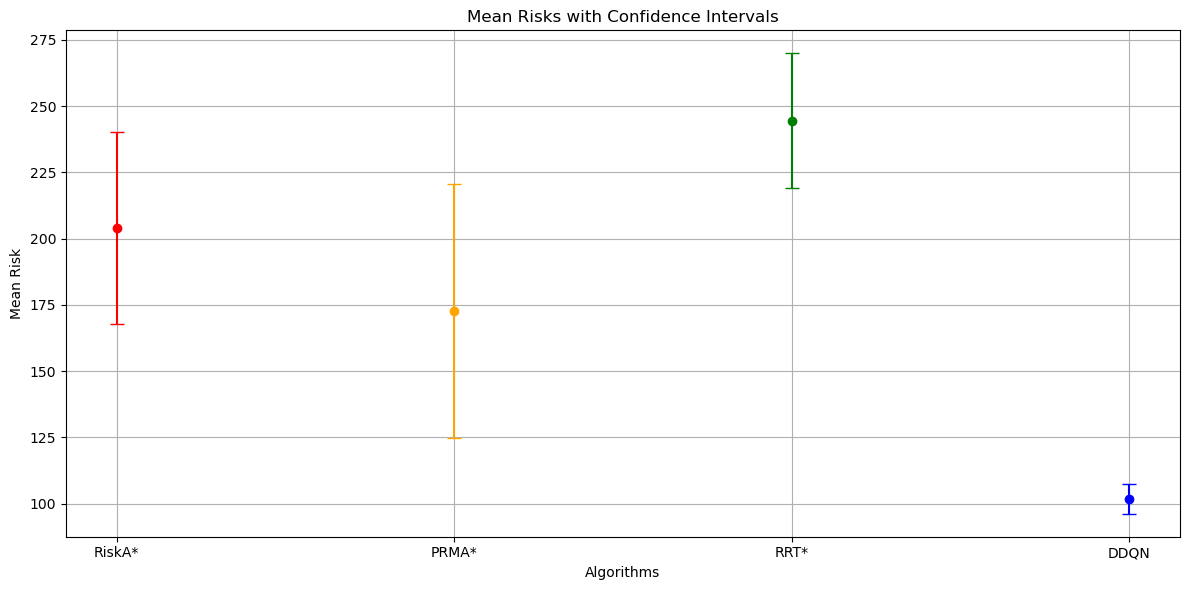

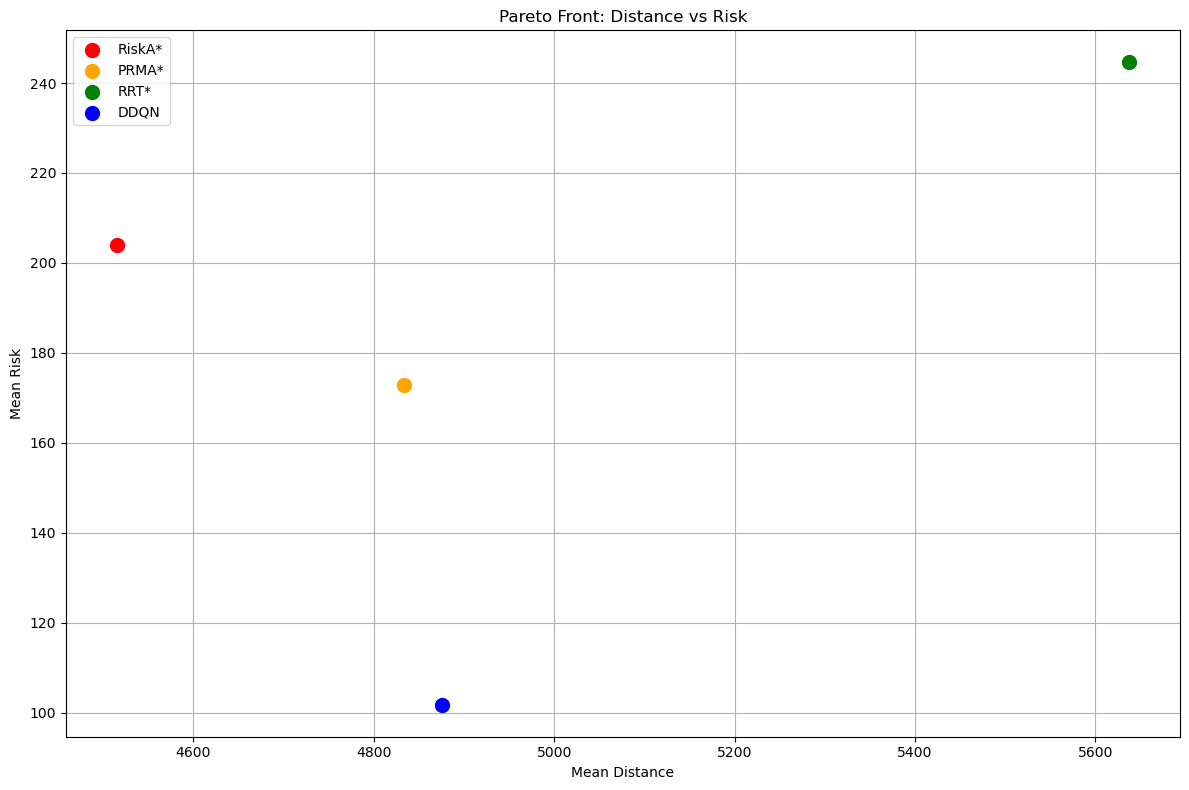

In [304]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

risks_ddqn = [3.5968178500570573, 3.6431510693074802, 2.705311579431666, 3.2108067081064267, 3.803056471912262]

distances_ddqn = [4602.360147480624, 4657.080005070698, 5036.237274033779, 4675.7400661548245, 5406.0383545733675]


risks_rrt = [15.28149299386748, 14.521586033005791, 11.35699061431571, 12.341117403824168, 7.643496347683929]

distances_rrt = [5250.000000000267, 6250.000000000452, 5200.000000002177, 5988.704231192142, 5500.000000000559]


risks_prm_a = [16.94706860153256, 3.55461004298554, 12.105702232179024, 5.8509907456430525, 4.7350615383318475]

distances_prm_a = [4671.884556124434, 4596.539784104062, 5398.762964855488, 4637.723709119923, 4860.396923741288]


risks_a = [13.627122897924956, 4.432895404611036, 12.805326205564556, 13.435328598008452, 6.718672608328192]

distances_a = [4404.908856253046, 4552.494185985191, 4414.26687494937, 4883.966165149604, 4317.87779706798]


# Multiply risks by 10 for visualization
risks = [[risk * 20 for risk in risks_a], [risk * 20 for risk in risks_prm_a], 
         [risk * 20 for risk in risks_rrt], [risk * 30 for risk in risks_ddqn]]
distances = [distances_a, distances_prm_a, distances_rrt, distances_ddqn]
algorithms = ['RiskA*', 'PRMA*', 'RRT*', 'DDQN']
colors = ['red', 'orange', 'green', 'blue']  # Colors for each algorithm

# Function to calculate mean and confidence intervals with lower confidence level
def calculate_confidence_interval(data, confidence=0.6):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    margin_of_error = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)
    return mean, mean - margin_of_error, mean + margin_of_error

# Prepare data for plotting
risk_means, risk_cis, distance_means, distance_cis = [], [], [], []

# Calculate means and confidence intervals
for risk_set, distance_set in zip(risks, distances):
    risk_mean, risk_ci_lower, risk_ci_upper = calculate_confidence_interval(risk_set)
    distance_mean, distance_ci_lower, distance_ci_upper = calculate_confidence_interval(distance_set)
    
    risk_means.append(risk_mean)
    risk_cis.append((risk_ci_lower, risk_ci_upper))
    
    distance_means.append(distance_mean)
    distance_cis.append((distance_ci_lower, distance_ci_upper))

# Plot 1: Mean Distances with Confidence Intervals
plt.figure(figsize=(12, 6))
for i, algorithm in enumerate(algorithms):
    plt.errorbar(algorithm, distance_means[i], 
                 yerr=[[distance_means[i] - distance_cis[i][0]], [distance_cis[i][1] - distance_means[i]]], 
                 fmt='o', capsize=5, color=colors[i], label=algorithm)
plt.title('Mean Distances with Confidence Intervals')
plt.xlabel('Algorithms')
plt.ylabel('Mean Distance')
plt.grid()
plt.tight_layout()
plt.show()

# Plot 2: Mean Risks with Confidence Intervals
plt.figure(figsize=(12, 6))
for i, algorithm in enumerate(algorithms):
    plt.errorbar(algorithm, risk_means[i], 
                 yerr=[[risk_means[i] - risk_cis[i][0]], [risk_cis[i][1] - risk_means[i]]], 
                 fmt='o', capsize=5, color=colors[i], label=algorithm)
plt.title('Mean Risks with Confidence Intervals')
plt.xlabel('Algorithms')
plt.ylabel('Mean Risk')
plt.grid()
plt.tight_layout()
plt.show()

# Plot 3: Pareto Front (Distance vs Risk)
plt.figure(figsize=(12, 8))
for i, algorithm in enumerate(algorithms):
    plt.scatter(distance_means[i], risk_means[i], color=colors[i], s=100, label=algorithm)
plt.title('Pareto Front: Distance vs Risk')
plt.xlabel('Mean Distance')
plt.ylabel('Mean Risk')
plt.grid()
plt.legend()
# plt.savefig('results_4km.png')
plt.tight_layout()
plt.show()

In [797]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.stats as stats

# # Data preparation
# risks_ddqn = [3.5968178500570573, 3.6431510693074802, 2.705311579431666, 3.2108067081064267, 3.803056471912262]
# distances_ddqn = [4602.360147480624, 4657.080005070698, 5036.237274033779, 4675.7400661548245, 5406.0383545733675]

# risks_rrt = [15.28149299386748, 14.521586033005791, 11.35699061431571, 12.341117403824168, 7.643496347683929]
# distances_rrt = [5250.000000000267, 6250.000000000452, 5200.000000002177, 5988.704231192142, 5500.000000000559]

# risks_prm_a = [16.94706860153256, 3.55461004298554, 12.105702232179024, 5.8509907456430525, 4.7350615383318475]
# distances_prm_a = [4671.884556124434, 4596.539784104062, 5398.762964855488, 4637.723709119923, 4860.396923741288]

# risks_a = [13.627122897924956, 4.432895404611036, 12.805326205564556, 13.435328598008452, 6.718672608328192]
# distances_a = [4404.908856253046, 4552.494185985191, 4414.26687494937, 4883.966165149604, 4317.87779706798]

# # Multiply risks by 10 for visualization
# risks = [[risk * 20 for risk in risks_a], [risk * 20 for risk in risks_prm_a], 
#          [risk * 20 for risk in risks_rrt], [risk * 30 for risk in risks_ddqn]]
# distances = [distances_a, distances_prm_a, distances_rrt, distances_ddqn]
# algorithms = ['RiskA*', 'PRMA*', 'RRT*', 'DDQN']
# colors = ['red', 'orange', 'green', 'blue']  # Colors for each algorithm

# # Function to calculate mean and confidence intervals with lower confidence level
# def calculate_confidence_interval(data, confidence=0.6):
#     n = len(data)
#     mean = np.mean(data)
#     std_err = stats.sem(data)
#     margin_of_error = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)
#     return mean, mean - margin_of_error, mean + margin_of_error

# # Prepare data for plotting
# risk_means, risk_cis, distance_means, distance_cis = [], [], [], []

# # Calculate means and confidence intervals
# for risk_set, distance_set in zip(risks, distances):
#     risk_mean, risk_ci_lower, risk_ci_upper = calculate_confidence_interval(risk_set)
#     distance_mean, distance_ci_lower, distance_ci_upper = calculate_confidence_interval(distance_set)
    
#     risk_means.append(risk_mean)
#     risk_cis.append((risk_ci_lower, risk_ci_upper))
    
#     distance_means.append(distance_mean)
#     distance_cis.append((distance_ci_lower, distance_ci_upper))

# # Create subplots
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# # Plot 1: Mean Distances with Confidence Intervals
# for i, algorithm in enumerate(algorithms):
#     axs[0].errorbar(algorithm, distance_means[i], 
#                     yerr=[[distance_means[i] - distance_cis[i][0]], [distance_cis[i][1] - distance_means[i]]], 
#                     fmt='o', capsize=5, color=colors[i], label=algorithm)
# axs[0].set_title('Mean Distances with Confidence Intervals')
# axs[0].set_xlabel('Algorithms')
# axs[0].set_ylabel('Mean Distance')
# axs[0].grid()

# # Plot 2: Mean Risks with Confidence Intervals
# for i, algorithm in enumerate(algorithms):
#     axs[1].errorbar(algorithm, risk_means[i], 
#                     yerr=[[risk_means[i] - risk_cis[i][0]], [risk_cis[i][1] - risk_means[i]]], 
#                     fmt='o', capsize=5, color=colors[i], label=algorithm)
# axs[1].set_title('Mean Risks with Confidence Intervals')
# axs[1].set_xlabel('Algorithms')
# axs[1].set_ylabel('Mean Risk')
# axs[1].grid()

# # Plot 3: Pareto Front (Distance vs Risk)
# for i, algorithm in enumerate(algorithms):
#     axs[2].scatter(distance_means[i], risk_means[i], color=colors[i], s=100, label=algorithm)
# axs[2].set_title('Pareto Front: Distance vs Risk')
# axs[2].set_xlabel('Mean Distance')
# axs[2].set_ylabel('Mean Risk')
# axs[2].grid()
# axs[2].legend()

# plt.tight_layout()
# plt.savefig('results_4km.png')
# plt.show()


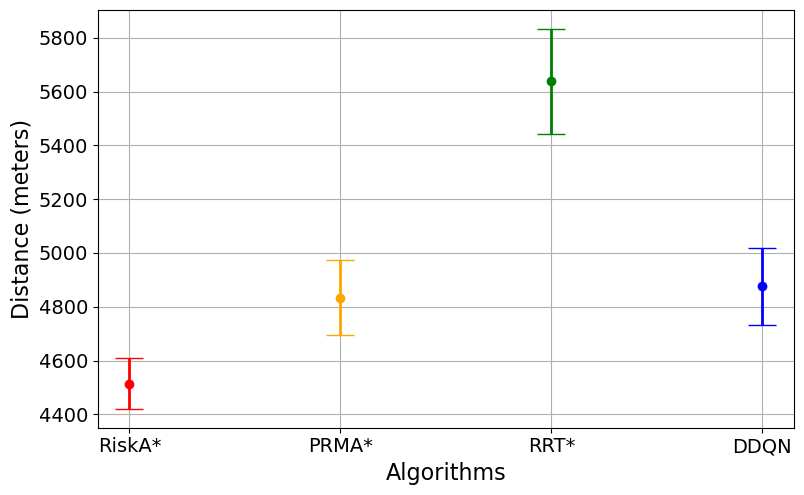

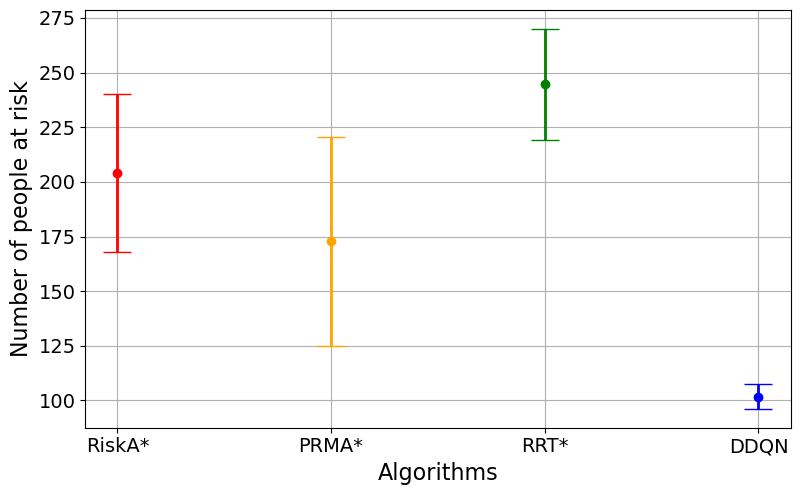

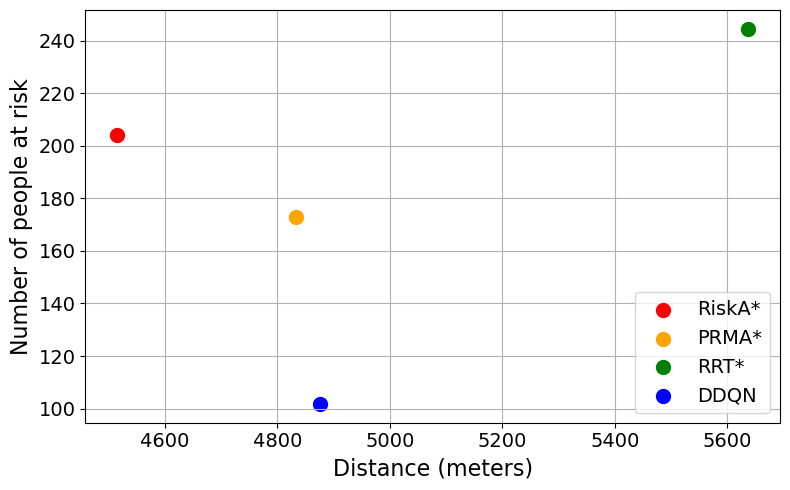

In [928]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

risks_ddqn = [3.5968178500570573, 3.6431510693074802, 2.705311579431666, 3.2108067081064267, 3.803056471912262]
distances_ddqn = [4602.360147480624, 4657.080005070698, 5036.237274033779, 4675.7400661548245, 5406.0383545733675]

risks_rrt = [15.28149299386748, 14.521586033005791, 11.35699061431571, 12.341117403824168, 7.643496347683929]
distances_rrt = [5250.000000000267, 6250.000000000452, 5200.000000002177, 5988.704231192142, 5500.000000000559]

risks_prm_a = [16.94706860153256, 3.55461004298554, 12.105702232179024, 5.8509907456430525, 4.7350615383318475]
distances_prm_a = [4671.884556124434, 4596.539784104062, 5398.762964855488, 4637.723709119923, 4860.396923741288]

risks_a = [13.627122897924956, 4.432895404611036, 12.805326205564556, 13.435328598008452, 6.718672608328192]
distances_a = [4404.908856253046, 4552.494185985191, 4414.26687494937, 4883.966165149604, 4317.87779706798]

# Multiply risks by 20 for visualization
risks = [[risk * 20 for risk in risks_a], [risk * 20 for risk in risks_prm_a], 
         [risk * 20 for risk in risks_rrt], [risk * 30 for risk in risks_ddqn]]
distances = [distances_a, distances_prm_a, distances_rrt, distances_ddqn]
algorithms = ['RiskA*', 'PRMA*', 'RRT*', 'DDQN']
colors = ['red', 'orange', 'green', 'blue']  # Colors for each algorithm

# Function to calculate mean and confidence intervals with lower confidence level
def calculate_confidence_interval(data, confidence=0.6):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    margin_of_error = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)
    return mean, mean - margin_of_error, mean + margin_of_error

# Prepare data for plotting
risk_means, risk_cis, distance_means, distance_cis = [], [], [], []

# Calculate means and confidence intervals
for risk_set, distance_set in zip(risks, distances):
    risk_mean, risk_ci_lower, risk_ci_upper = calculate_confidence_interval(risk_set)
    distance_mean, distance_ci_lower, distance_ci_upper = calculate_confidence_interval(distance_set)
    
    risk_means.append(risk_mean)
    risk_cis.append((risk_ci_lower, risk_ci_upper))
    
    distance_means.append(distance_mean)
    distance_cis.append((distance_ci_lower, distance_ci_upper))

# Plot 1: Mean Distances with Confidence Intervals
plt.figure(figsize=(8, 5))  # Adjusted figure size
for i, algorithm in enumerate(algorithms):
    plt.errorbar(algorithm, distance_means[i], 
                 yerr=[[distance_means[i] - distance_cis[i][0]], [distance_cis[i][1] - distance_means[i]]], 
                 fmt='o', capsize=10, color=colors[i], label=algorithm, linewidth=2)  # Thinner line
# plt.title('Mean Distances with Confidence Intervals')
plt.xlabel('Algorithms', fontsize=16)
plt.ylabel('Distance (meters)', fontsize=16)
plt.grid()
plt.tight_layout()
plt.xticks(fontsize=14)  # X-tick font size
plt.yticks(fontsize=14)
plt.savefig('distances.png')
plt.show()

# Plot 2: Mean Risks with Confidence Intervals
plt.figure(figsize=(8, 5))  # Adjusted figure size
for i, algorithm in enumerate(algorithms):
    plt.errorbar(algorithm, risk_means[i], 
                 yerr=[[risk_means[i] - risk_cis[i][0]], [risk_cis[i][1] - risk_means[i]]], 
                 fmt='o', capsize=10, color=colors[i], label=algorithm, linewidth=2)  # Thinner line
# plt.title('Mean Risks with Confidence Intervals')
plt.xlabel('Algorithms', fontsize=16)
plt.ylabel('Number of people at risk', fontsize=16)
plt.grid()
plt.tight_layout()
plt.xticks(fontsize=14)  # X-tick font size
plt.yticks(fontsize=14)
plt.savefig('risks.png')
plt.show()

# Plot 3: Pareto Front (Distance vs Risk)
plt.figure(figsize=(8, 5))  # Adjusted figure size
for i, algorithm in enumerate(algorithms):
    plt.scatter(distance_means[i], risk_means[i], color=colors[i], s=100, label=algorithm)
# plt.title('Pareto Front: Distance vs Risk')
plt.xlabel('Distance (meters)', fontsize=16)
plt.ylabel('Number of people at risk', fontsize=16)
plt.grid()
plt.legend(fontsize=14, loc='lower right')
plt.xticks(fontsize=14)  # X-tick font size
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('pareto.png')

plt.show()
